# Reporte de Progreso del Análisis de Parámetros de Trazas

Este notebook consolida el progreso del análisis de parámetros de trazas de datos, dividiendo el trabajo en etapas lógicas y externalizando las funciones para una mayor modularidad y reusabilidad del código.

## 1. Extracción y Análisis Inicial de Parámetros Numéricos

Esta sección abarca la carga inicial de datos, la identificación de TPL_IDs (Trace Product Level Identifiers), la separación de metadatos con y sin errores, y la extracción de parámetros numéricos de las trazas para su descripción y visualización.

### Importar Librerías y Funciones
Se importan las librerías necesarias y las funciones externalizadas de los módulos `src/preprocesamiento`, `src/visualizacion`, `src/codificacion` y `src/clustering`.

In [1]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
import os
import matplotlib.pyplot as plt

# Importar funciones externalizadas de la carpeta 'src'
from src.preprocesamiento import extract_params, extract_trace_parameters, cargar_y_procesar_carpeta, extract_trace_categoricals,min_max_normalizar
from src.visualizacion import graficos_dispersion_por_columna
from src.codificacion import codificar_categoricas_por_columna, procesar_strval_in_memory 
from src.clustering import aplicar_tsne_dbscan, aplicar_umap_dbscan, cluster_y_con_tsne,procesar_archivos_especificos, plot_combined_clusters,cluster_and_plot_combined

plt.style.use('default')
plt.rcParams['font.size'] = 10

### Cargar datos del dataset Eliana
* Instrumento: MATISSE
* Rango de tiempo: 6 meses

In [8]:
INSTRUMENT='MATISSE'
RANGE='6m'

In [9]:
logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)

### Información General de los DataFrames

In [10]:
df_meta = logs.meta
df_traces = logs.traces()
TPL_IDs = logs.meta['TPL_ID'].value_counts()
print("Conteo de TPL_IDs:\n", TPL_IDs)

Conteo de TPL_IDs:
 TPL_ID
MATISSE_hyb_obs                      1612
MATISSE_img_acq                      1467
MATISSE_gen_tec_opd                  1059
MATISSE_gen_cal_bias                  724
MATISSE_gen_cal_imbasic               399
MATISSE_gen_cal_transfunc             241
MATISSE_gen_tec_standby               199
MATISSE_gen_tec_ali                   185
MATISSE_gen_tec_check_fringes         183
MATISSE_img_acq_ft                    174
MATISSE_gen_tec_simple_rec            130
MATISSE_gen_cal_kappa                  56
MATISSE_gen_cal_shift                  50
CALOB_gen_tec_log                      37
errseverity                            33
MATISSE_gen_tec_setup_coude_train      27
MATISSE_gen_cal_det_aq                 22
MATISSE_gen_cal_det_h2                 21
MATISSE_gen_tec_piezos                 13
MATISSE_gen_tec_setup_lab               7
MATISSE_gen_cal_imext_aq                5
MATISSE_gen_cal_imrem_aq                3
MATISSE_gen_cal_imrem                   2
MATISSE

In [11]:
TPL_IDs_Error=df_meta[df_meta['ERROR'] == True]
print("Conteo de TPL_IDs con ERROR:\n", TPL_IDs_Error['TPL_ID'].value_counts())

Conteo de TPL_IDs con ERROR:
 TPL_ID
MATISSE_gen_tec_ali              67
MATISSE_hyb_obs                  43
MATISSE_img_acq                  39
errseverity                      27
MATISSE_img_acq_ft               23
MATISSE_gen_tec_opd              20
MATISSE_gen_cal_det_aq           15
MATISSE_gen_tec_check_fringes    10
MATISSE_gen_cal_bias              9
MATISSE_gen_cal_imbasic           6
MATISSE_gen_cal_det_h2            3
MATISSE_gen_cal_shift             3
MATISSE_gen_cal_kappa             2
MATISSE_gen_tec_piezos            2
MATISSE_gen_cal_transfunc         1
Name: count, dtype: int64


In [12]:
TPL = set(TPL_IDs.index) & set(TPL_IDs_Error['TPL_ID'])
print("TPL_IDs con errores comunes:\n", TPL)

TPL_IDs con errores comunes:
 {'MATISSE_gen_cal_transfunc', 'MATISSE_gen_tec_check_fringes', 'MATISSE_gen_tec_piezos', 'MATISSE_gen_tec_ali', 'MATISSE_gen_cal_imbasic', 'MATISSE_img_acq', 'MATISSE_gen_cal_bias', 'MATISSE_hyb_obs', 'errseverity', 'MATISSE_gen_cal_det_h2', 'MATISSE_gen_cal_shift', 'MATISSE_img_acq_ft', 'MATISSE_gen_cal_det_aq', 'MATISSE_gen_tec_opd', 'MATISSE_gen_cal_kappa'}


In [13]:
print("Conteo de errores en metadatos:\n", df_meta['ERROR'].value_counts())

Conteo de errores en metadatos:
 ERROR
False    6383
True      270
Name: count, dtype: int64


### Separar los dataframes en dos: sin errores y con errores
Se crean dos DataFrames de metadatos: uno para las observaciones con errores (`df_meta_Error`) y otro para las que no tienen errores (`df_meta_2`).

In [14]:
df_meta_Error = df_meta[df_meta['ERROR'] == True]

In [15]:
df_meta_2 = df_meta[~df_meta['START'].isin(df_meta_Error['START'])]

### Extracción y Almacenamiento de Parámetros Numéricos
Se extraen los parámetros numéricos de las trazas para los TPL_IDs identificados, tanto para las observaciones sin error como para las que tienen error. Los resultados se almacenan en diccionarios en memoria.

In [12]:
output_dir_ok_num = "params_por_tpl"
output_dir_err_num = "params_por_tpl_Error"

os.makedirs(output_dir_ok_num, exist_ok=True)
os.makedirs(output_dir_err_num, exist_ok=True)

tpl_params_dict_ok = {}
tpl_params_dict_err = {}

threshold_nan = 0.5

for tpl_id in TPL:
    print(f"Procesando TPL_ID (Numérico, Sin Error): {tpl_id}")
    params_df_ok = extract_trace_parameters(df_meta_2, df_traces, extract_params, tpl_id=tpl_id)
    
    params_df_ok = params_df_ok.loc[:, params_df_ok.isna().mean() < threshold_nan]
    params_df_ok = params_df_ok.loc[params_df_ok.isna().mean(axis=1) < threshold_nan, :]

    if not params_df_ok.empty:
        tpl_params_dict_ok[tpl_id] = params_df_ok
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename_ok = os.path.join(output_dir_ok_num, f"params_{safe_tpl_id}.csv")
        params_df_ok.to_csv(filename_ok)
        print(f"Guardado opcional: {filename_ok}")
    else:
        print(f"No se generó DataFrame (Numérico, sin error) para {tpl_id} después del filtrado.")

    print(f"Procesando TPL_ID (Numérico, Con Error): {tpl_id}")
    params_df_err = extract_trace_parameters(df_meta_Error, df_traces, extract_params, tpl_id=tpl_id)
    
    params_df_err = params_df_err.loc[:, params_df_err.isna().mean() < threshold_nan]
    params_df_err = params_df_err.loc[params_df_err.isna().mean(axis=1) < threshold_nan, :]

    if not params_df_err.empty:
        tpl_params_dict_err[tpl_id] = params_df_err
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename_err = os.path.join(output_dir_err_num, f"params_{safe_tpl_id}.csv")
        params_df_err.to_csv(filename_err)
        print(f"Guardado opcional: {filename_err}")
    else:
        print(f"No se generó DataFrame (Numérico, con error) para {tpl_id} después del filtrado.")

Procesando TPL_ID (Numérico, Sin Error): MATISSE_gen_cal_shift
Guardado opcional: params_por_tpl\params_MATISSE_gen_cal_shift.csv
Procesando TPL_ID (Numérico, Con Error): MATISSE_gen_cal_shift
Guardado opcional: params_por_tpl_Error\params_MATISSE_gen_cal_shift.csv
Procesando TPL_ID (Numérico, Sin Error): MATISSE_gen_cal_kappa
Guardado opcional: params_por_tpl\params_MATISSE_gen_cal_kappa.csv
Procesando TPL_ID (Numérico, Con Error): MATISSE_gen_cal_kappa
Guardado opcional: params_por_tpl_Error\params_MATISSE_gen_cal_kappa.csv
Procesando TPL_ID (Numérico, Sin Error): MATISSE_gen_cal_det_aq
Guardado opcional: params_por_tpl\params_MATISSE_gen_cal_det_aq.csv
Procesando TPL_ID (Numérico, Con Error): MATISSE_gen_cal_det_aq
Guardado opcional: params_por_tpl_Error\params_MATISSE_gen_cal_det_aq.csv
Procesando TPL_ID (Numérico, Sin Error): errseverity
Guardado opcional: params_por_tpl\params_errseverity.csv
Procesando TPL_ID (Numérico, Con Error): errseverity
Guardado opcional: params_por_tpl_E

### Descripción Estadística de Parámetros Numéricos


In [13]:
print("\n--- Descripción de Parámetros Numéricos Sin Error ---")
for tpl_id, df in tpl_params_dict_ok.items():
    if not df.empty:
        print("\n" + "="*100)
        print(f" Descripción de: params_{str(tpl_id).replace('/', '_').replace(' ', '_')}.csv (Sin Error)")
        print("="*100)
        desc = df.select_dtypes(include='number').describe().T.round(2) 
        print(desc)
    else:
        print(f"DataFrame vacío para {tpl_id} (Sin Error).")

print("\n--- Descripción de Parámetros Numéricos Con Error ---")
for tpl_id, df in tpl_params_dict_err.items():
    if not df.empty:
        print("\n" + "="*100)
        print(f" Descripción de: params_{str(tpl_id).replace('/', '_').replace(' ', '_')}.csv (Con Error)")
        print("="*100)
        desc = df.select_dtypes(include='number').describe().T.round(2) 
        print(desc)
    else:
        print(f"DataFrame vacío para {tpl_id} (Con Error).")


--- Descripción de Parámetros Numéricos Sin Error ---

 Descripción de: params_MATISSE_gen_cal_shift.csv (Sin Error)
           count    mean     std     min     25%     50%     75%     max
param                                                                   
DET1.DIT    47.0    0.45    1.04    0.02    0.02    0.08    0.20     5.0
DET1.NDIT   47.0  372.55  384.67   10.00  100.00  100.00  700.00  1000.0
DET2.DIT    47.0    0.04    0.04    0.02    0.03    0.03    0.03     0.2
DET2.NDIT   47.0  200.00  279.75  100.00  100.00  100.00  100.00  1000.0

 Descripción de: params_MATISSE_gen_cal_kappa.csv (Sin Error)
           count    mean   std     min     25%     50%     75%     max
param                                                                 
DET1.DIT    54.0    0.23  0.18    0.04    0.08    0.20    0.50    0.50
DET1.NDIT   54.0  100.00  0.00  100.00  100.00  100.00  100.00  100.00
DET2.DIT    54.0    0.03  0.00    0.03    0.03    0.03    0.03    0.03
DET2.NDIT   54.0   10.00  

### Gráficos de Dispersión de Parámetros Numéricos
Se generan gráficos de dispersión para comparar los parámetros numéricos entre las observaciones con y sin error, omitiendo los parámetros que se mantienen constantes en ambos grupos. Se procesan solo los archivos específicos para este reporte.

Generando gráficos para los TPL_IDs: MATISSE_hyb_obs, MATISSE_img_acq, MATISSE_img_acq_ft

Comparando MATISSE_hyb_obs.csv
Creando gráficos para 17 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOY.VAL', 'DET1.SNRLIMIT.VAL', 'TEL.CHOP.POSANG', 'SEQ.OPDM.L.WLMAX', 'DET1.INTERFY.VAL', 'DET2.INTERFX.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.APOY.VAL', 'DET1.APOX.VAL', 'TEL.CHOP.PVRATIO', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET1.APOTYPE.VAL', 'DET1.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.WLMINCUT.VAL', 'SEQ.OPDM.N.WLMAX', 'DET1.NINCOHERENT.VAL', 'DET1.NCOHERENT.VAL']
Observaciones sin error: 1569
Observaciones con error: 43


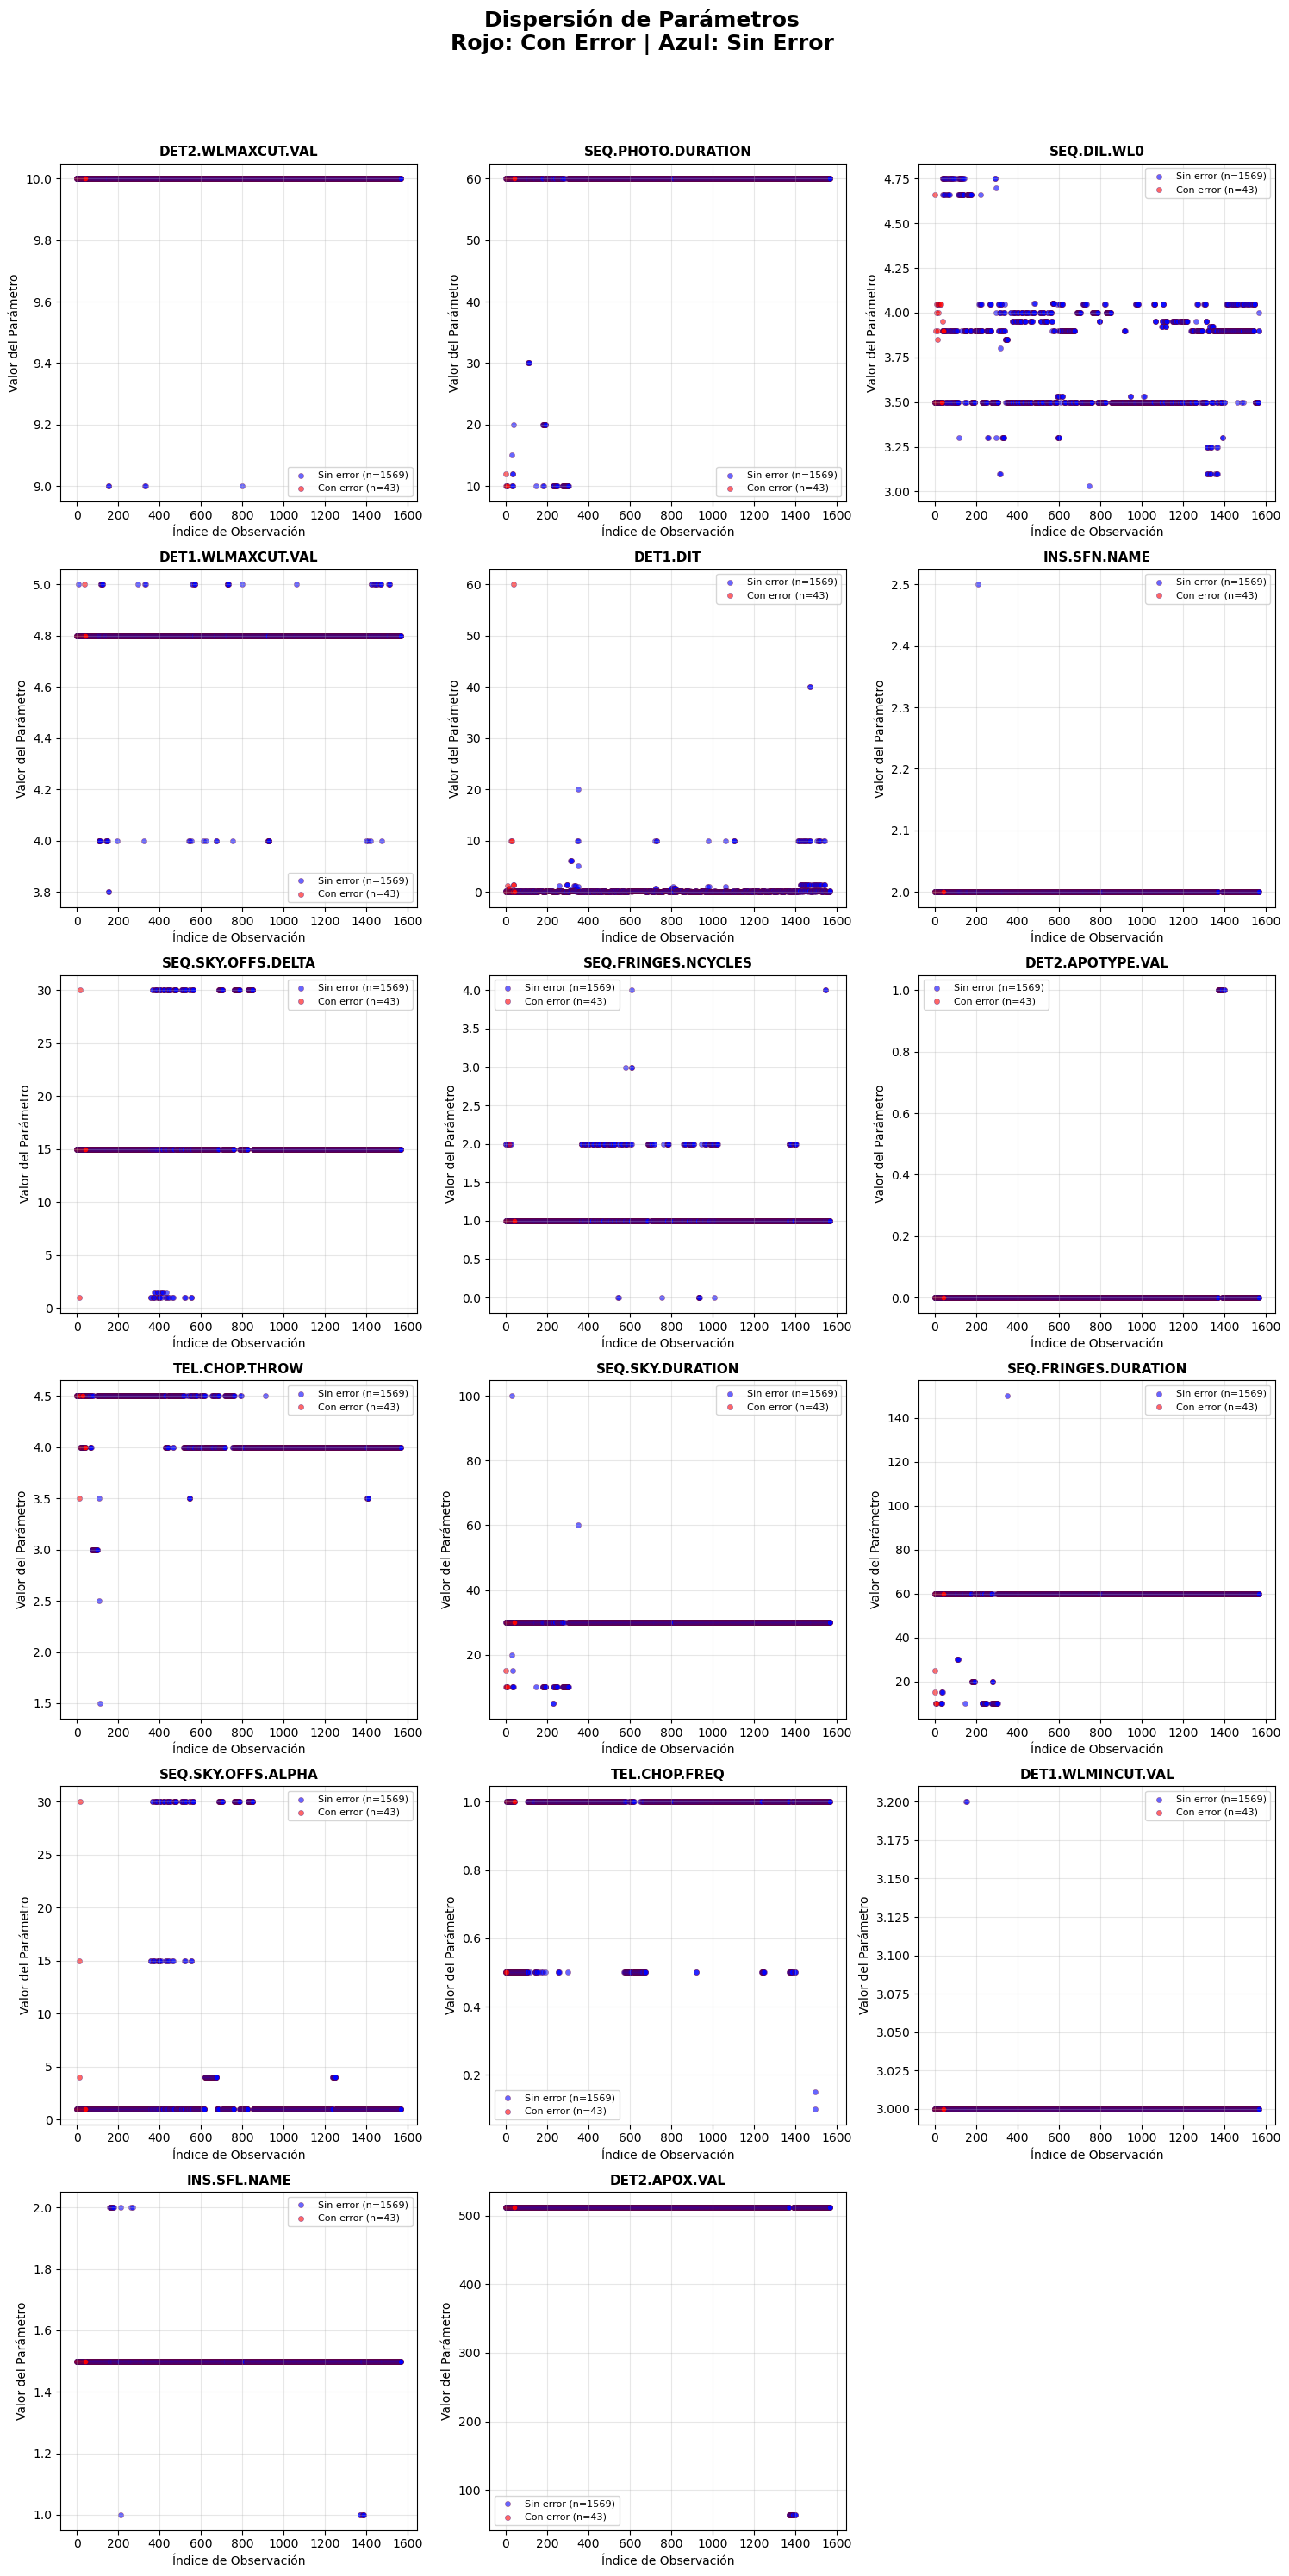


Comparando MATISSE_img_acq.csv
Creando gráficos para 27 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOY.VAL', 'DET2.WLMAXCUT.VAL', 'DET1.SNRLIMIT.VAL', 'SEQ.DIL.WL0', 'DEL.REF.OPL', 'TEL.GS1.ALPHA', 'SEQ.ACQ.TARG.DURATION', 'DET1.INTERFY.VAL', 'SEQ.OPDM.L.WLMAX', 'DET2.INTERFX.VAL', 'SEQ.PUP.SKY.DURATION', 'TEL.GS1.DELTA', 'DET2.SNRLIMIT.VAL', 'SEQ.FS.SKY.DURATION', 'DET2.APOY.VAL', 'COU.AG.EQUINOX', 'SEQ.SKY.OFFS.DELTA', 'COU.AG.EPOCH', 'DET1.APOX.VAL', 'TEL.CHOP.PVRATIO', 'DET2.NCOHERENT.VAL', 'SEQ.ACQ.SKY.DURATION', 'DET1.APOTYPE.VAL', 'DET1.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.WLMINCUT.VAL', 'SEQ.FS.INS.SFN.NAME', 'SEQ.OPDM.N.WLMAX', 'SEQ.SKY.OFFS.ALPHA', 'TEL.TARG.EQUINOX', 'TEL.GS1.MAG', 'SEQ.PUP.TARG.DURATION', 'DET1.NINCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET1.NCOHERENT.VAL']
Observaciones sin error: 1425
Observaciones con error: 38


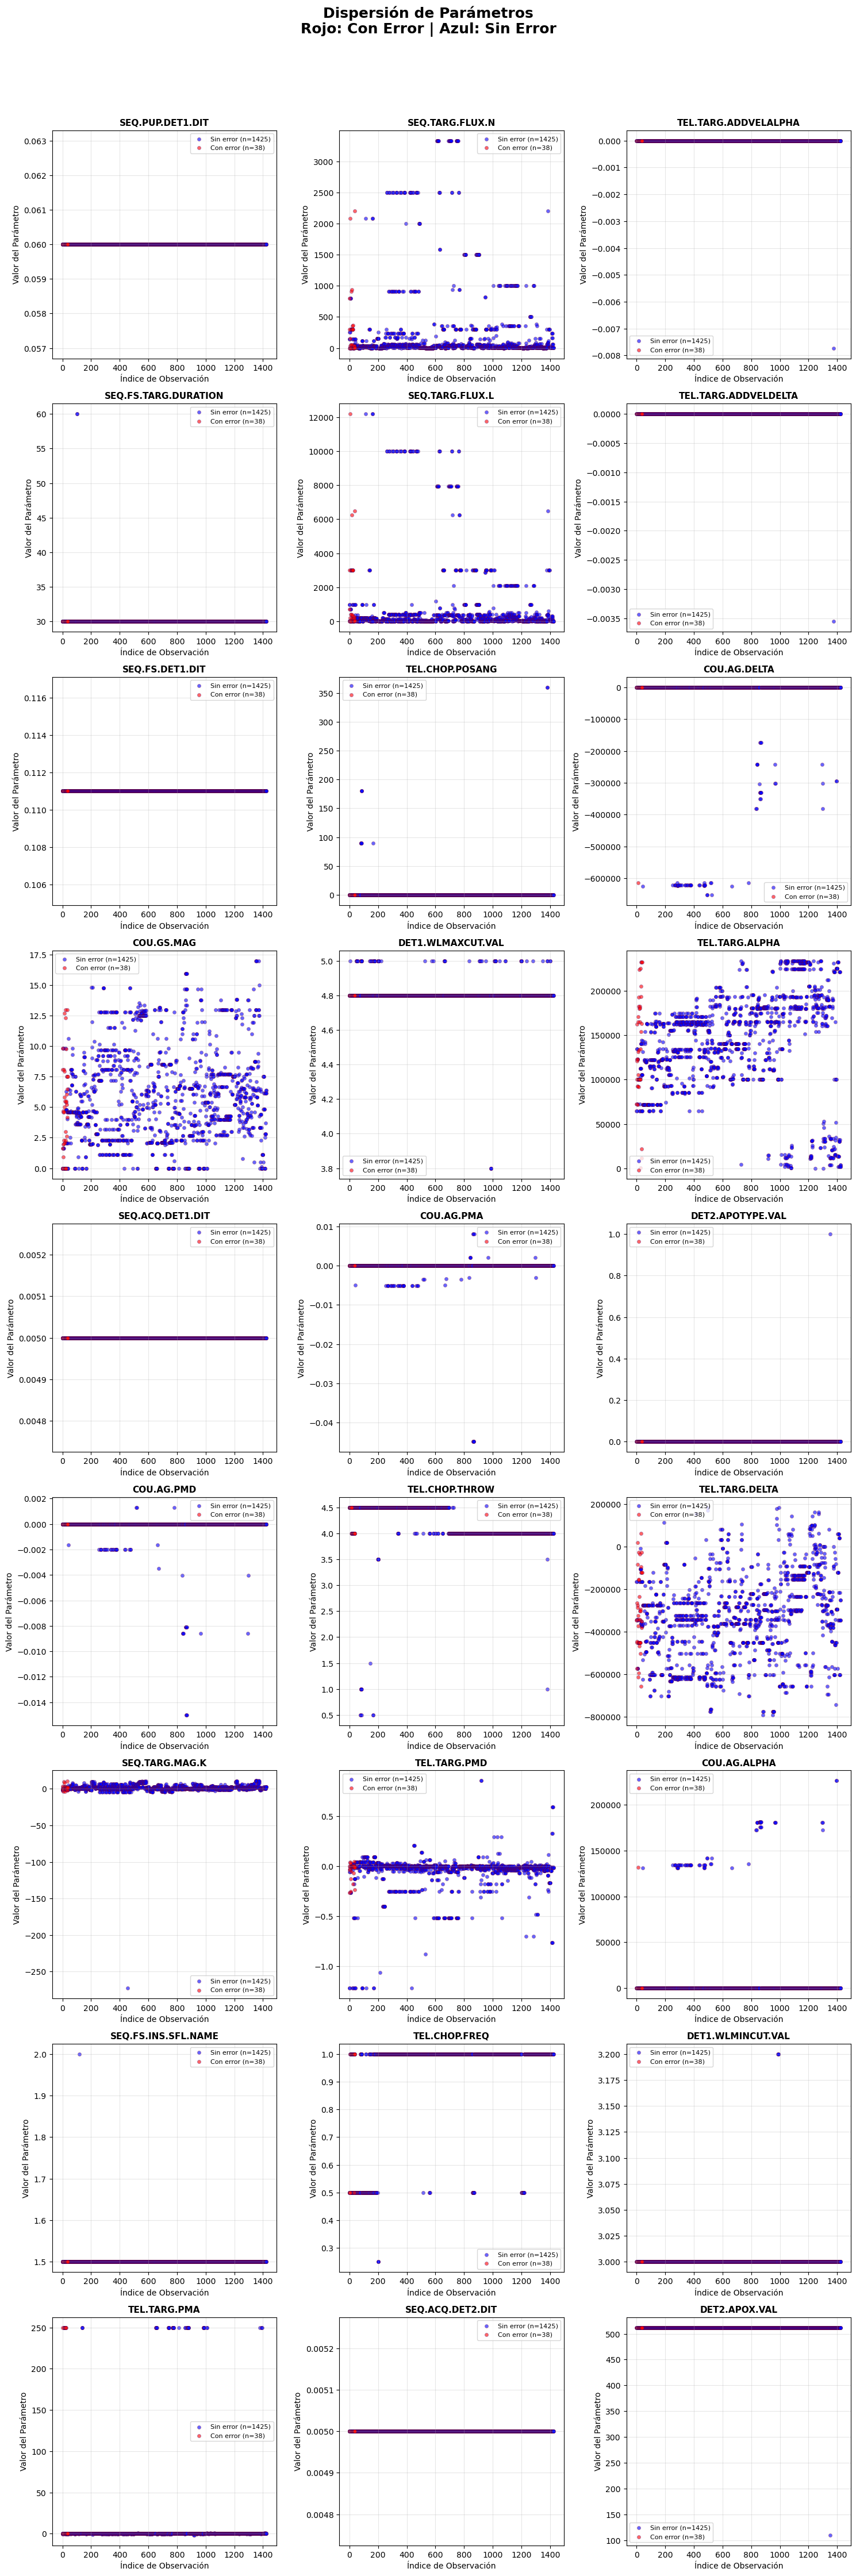


Comparando MATISSE_img_acq_ft.csv
Creando gráficos para 15 parámetros NO constantes...
Parámetros constantes (omitidos): ['TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'DET1.APOY.VAL', 'DET1.SNRLIMIT.VAL', 'COU.AG.DELTA', 'SEQ.DIL.WL0', 'DEL.REF.OPL', 'TEL.GS1.ALPHA', 'SEQ.ACQ.TARG.DURATION', 'SEQ.OPDM.L.WLMAX', 'SEQ.PUP.SKY.DURATION', 'DET2.INTERFX.VAL', 'DET1.INTERFY.VAL', 'TEL.GS1.DELTA', 'DET2.SNRLIMIT.VAL', 'DET2.APOY.VAL', 'INS.STSOFFANG', 'COU.AG.EQUINOX', 'SEQ.SKY.OFFS.DELTA', 'COU.AG.EPOCH', 'COU.AG.PMA', 'DET2.APOTYPE.VAL', 'DET1.APOX.VAL', 'COU.AG.PMD', 'DEL.REF.NAME', 'SEQ.SKY.Y', 'SEQ.SKY.X', 'DET2.NCOHERENT.VAL', 'SEQ.ACQ.SKY.DURATION', 'DET1.APOTYPE.VAL', 'DET1.INTERFX.VAL', 'DET2.NDIT.SKY', 'COU.AG.ALPHA', 'DET2.INTERFY.VAL', 'DET2.WLMINCUT.VAL', 'SEQ.SKY.OFFS.ALPHA', 'SEQ.OPDM.N.WLMAX', 'TEL.TARG.EQUINOX', 'TEL.GS1.MAG', 'SEQ.PUP.TARG.DURATION', 'DET1.WLMINCUT.VAL', 'DET1.NINCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET1.NCOHERENT.VAL', 'DET2.APOX.VAL']
Observaciones 

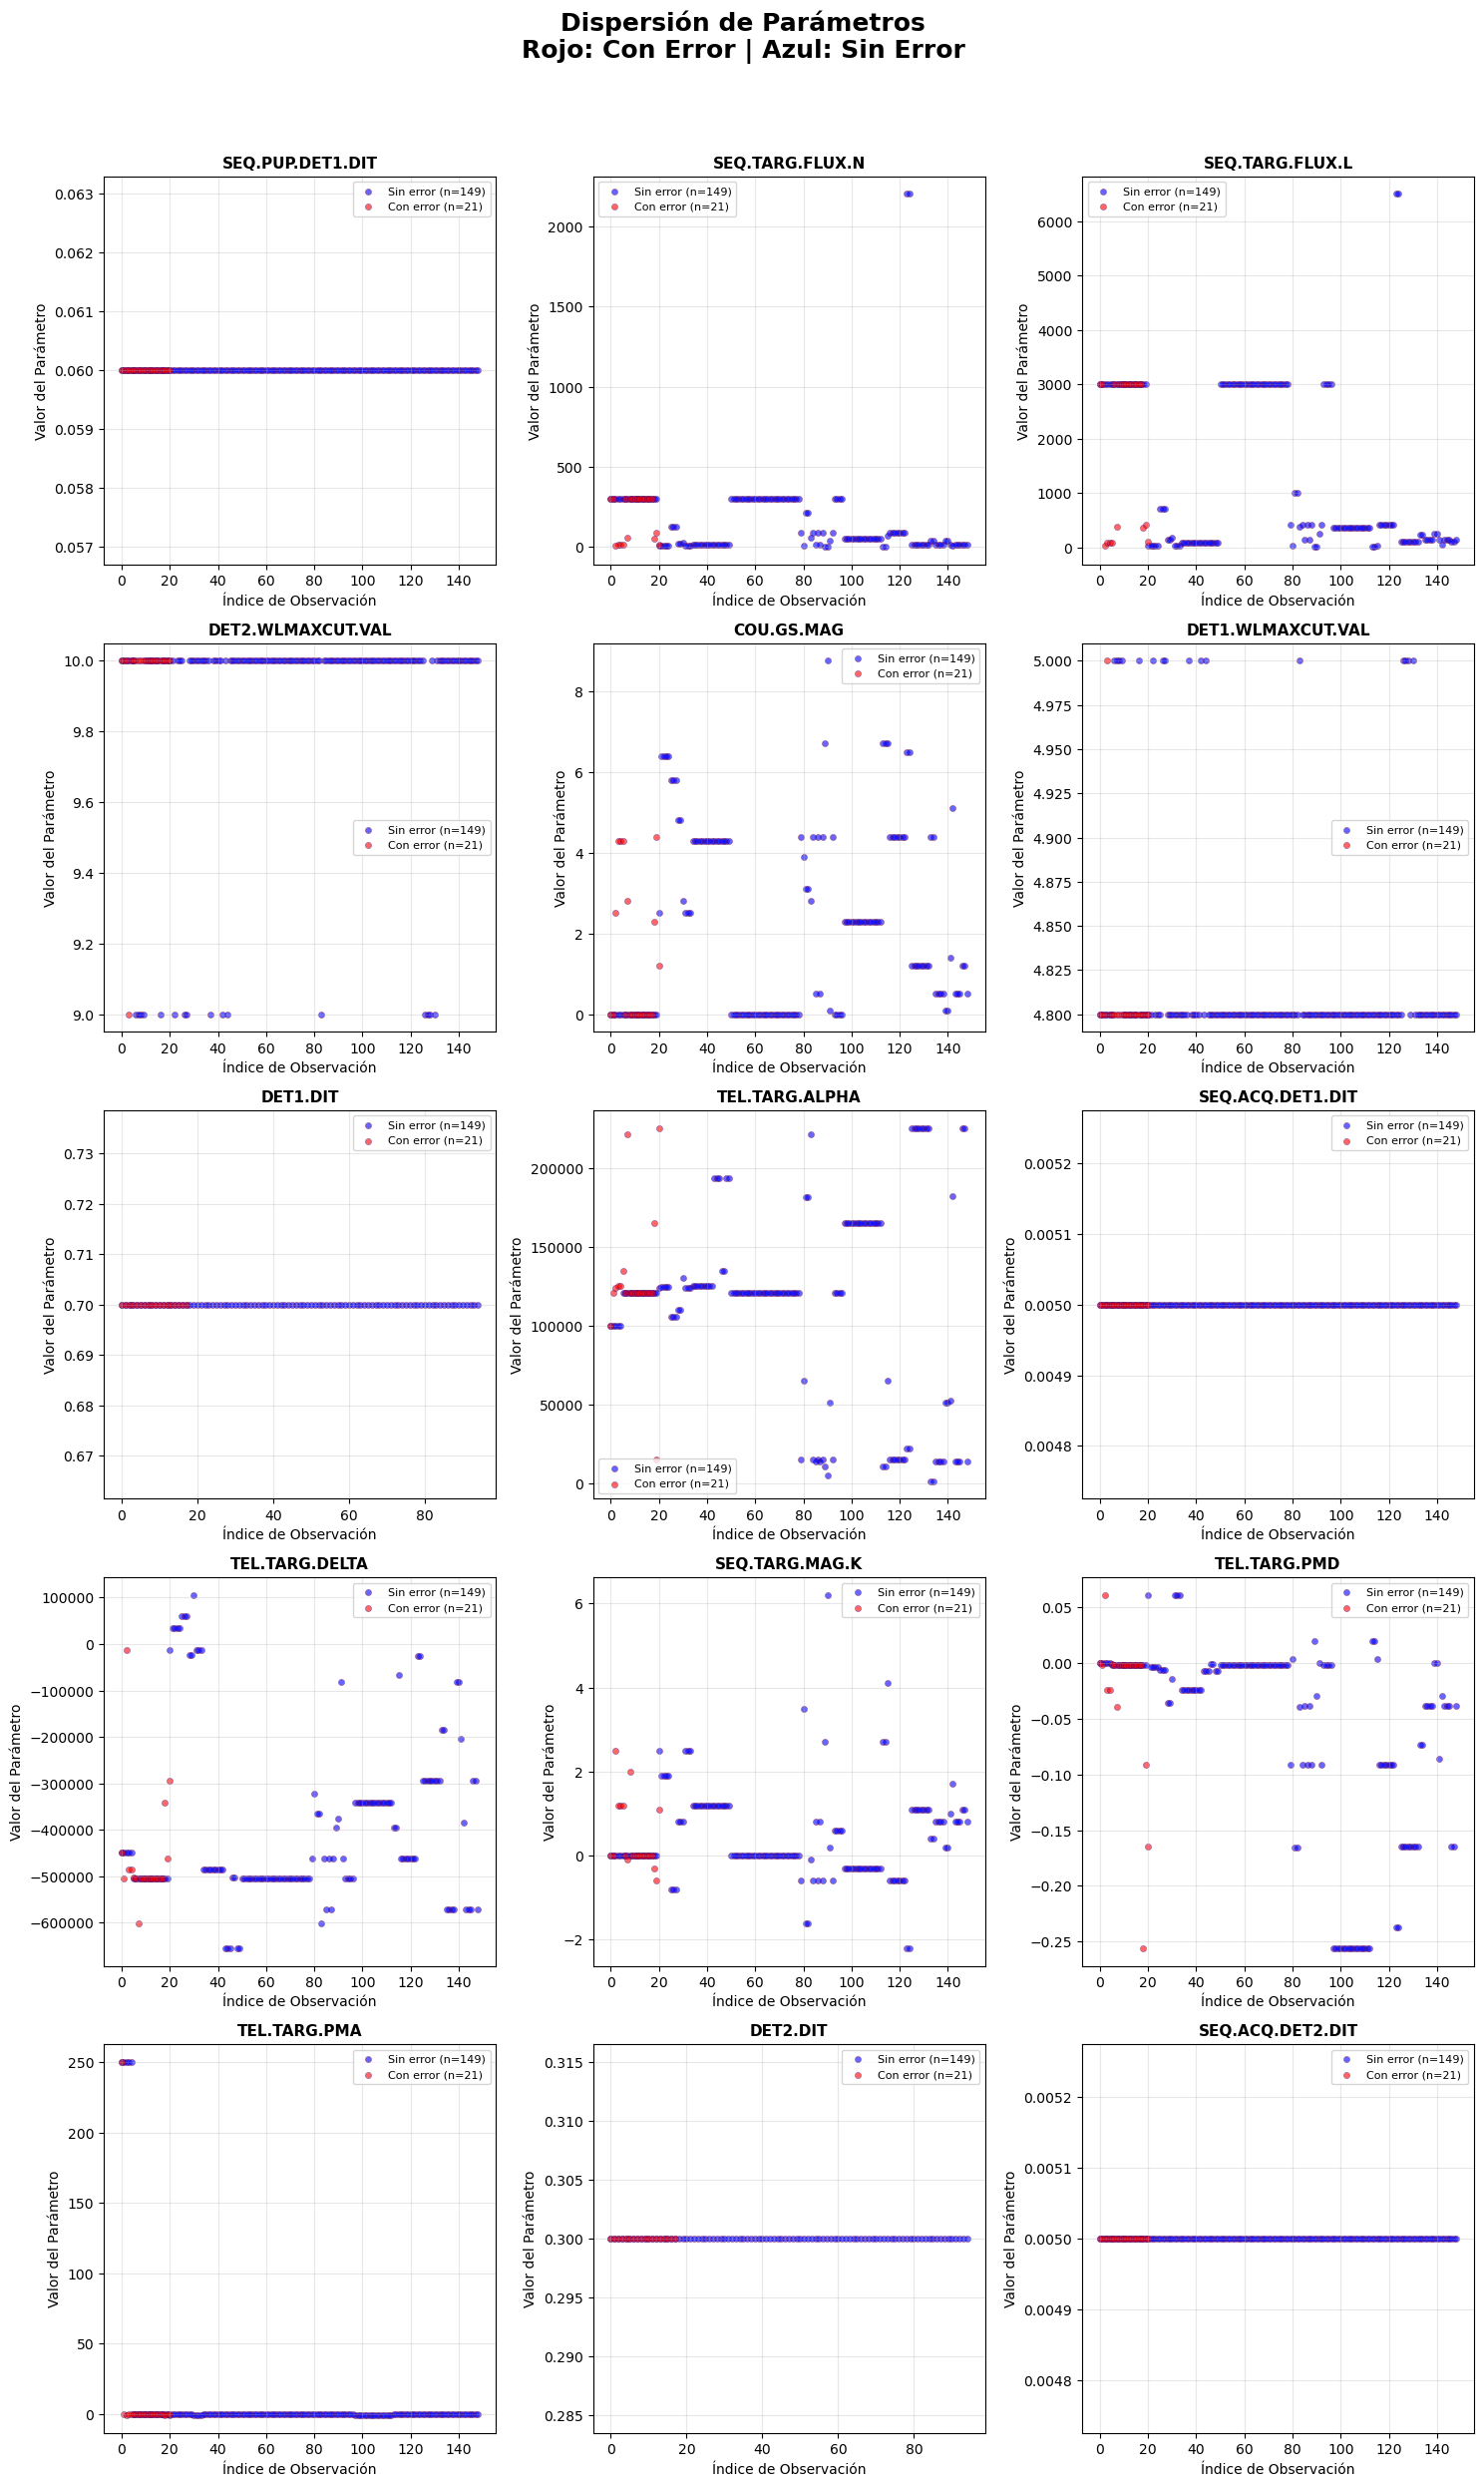

In [14]:
# Lista de archivos específicos a procesar para gráficos (TPL_IDs)
archivos_especificos_tpls = [
    'MATISSE_hyb_obs',
    'MATISSE_img_acq',
    'MATISSE_img_acq_ft'
]

print(f"Generando gráficos para los TPL_IDs: {', '.join(archivos_especificos_tpls)}")

for tpl_id_str in archivos_especificos_tpls:
    df_ok = tpl_params_dict_ok.get(tpl_id_str)
    df_err = tpl_params_dict_err.get(tpl_id_str)

    if df_ok is not None and not df_ok.empty and df_err is not None and not df_err.empty:
        print(f"\nComparando {tpl_id_str}.csv")
        columns = list(set(df_ok.columns) & set(df_err.columns))
        if columns:
            graficos_dispersion_por_columna(df_ok[columns], df_err[columns])
        else:
            print(f"No hay columnas comunes para comparar en {tpl_id_str}.csv.")
    else:
        print(f"No se encontraron DataFrames válidos (sin error o con error) para {tpl_id_str}. Se omite.")

## 2. Extracción y Codificación de Parámetros Categóricos

Esta sección se enfoca en la identificación y extracción de parámetros con valores categóricos y su posterior codificación numérica para facilitar futuros análisis. 

### Extracción de Parámetros Categóricos (strval) en Memoria
Se extraen los parámetros categóricos de las trazas y se almacenan directamente en diccionarios de DataFrames en memoria. 

In [21]:
tpl_strval_dict_ok = {}
tpl_strval_dict_err = {}

for tpl_id in TPL:
    # --- Procesamiento de DataFrames Sin Error (Categóricos) ---
    print(f"Procesando TPL_ID (Categórico, Sin Error): {tpl_id}")
    strval_df_ok = extract_trace_categoricals(df_meta_2, df_traces, extract_params, tpl_id=tpl_id)

    if not strval_df_ok.empty:
        tpl_strval_dict_ok[tpl_id] = strval_df_ok
    else:
        print(f"No se generó DataFrame (Categórico, sin error) para {tpl_id} después del filtrado.")

    # --- Procesamiento de DataFrames Con Error (Categóricos) ---
    print(f"Procesando TPL_ID (Categórico, Con Error): {tpl_id}")
    strval_df_err = extract_trace_categoricals(
        df_meta_Error,
        df_traces,
        extract_params,
        tpl_id=tpl_id
    )

    if not strval_df_err.empty:
        tpl_strval_dict_err[tpl_id] = strval_df_err
    else:
        print(f"No se generó DataFrame (Categórico, con error) para {tpl_id} después del filtrado.")


Procesando TPL_ID (Categórico, Sin Error): MATISSE_gen_cal_transfunc
Procesando TPL_ID (Categórico, Con Error): MATISSE_gen_cal_transfunc
Procesando TPL_ID (Categórico, Sin Error): MATISSE_gen_tec_check_fringes
Procesando TPL_ID (Categórico, Con Error): MATISSE_gen_tec_check_fringes
Procesando TPL_ID (Categórico, Sin Error): MATISSE_gen_tec_piezos
Procesando TPL_ID (Categórico, Con Error): MATISSE_gen_tec_piezos
Procesando TPL_ID (Categórico, Sin Error): MATISSE_gen_tec_ali
Procesando TPL_ID (Categórico, Con Error): MATISSE_gen_tec_ali
Procesando TPL_ID (Categórico, Sin Error): MATISSE_gen_cal_imbasic
Procesando TPL_ID (Categórico, Con Error): MATISSE_gen_cal_imbasic
Procesando TPL_ID (Categórico, Sin Error): MATISSE_img_acq
Procesando TPL_ID (Categórico, Con Error): MATISSE_img_acq
Procesando TPL_ID (Categórico, Sin Error): MATISSE_gen_cal_bias
Procesando TPL_ID (Categórico, Con Error): MATISSE_gen_cal_bias
Procesando TPL_ID (Categórico, Sin Error): MATISSE_hyb_obs
Procesando TPL_ID (

### Codificación de Parámetros Categóricos en Memoria
Se aplica una codificación numérica a los parámetros categóricos directamente desde los DataFrames en memoria. El diccionario de mapeo se guarda en un archivo JSON.

In [22]:
codified_strval_ok_dfs, dict_codificacion_ok = procesar_strval_in_memory(
    tpl_strval_dict_ok
)

codified_strval_err_dfs, dict_codificacion_err = procesar_strval_in_memory(
    tpl_strval_dict_err
)

print("\nCodificación de categóricas completada.")


Codificación de categóricas completada.


### Gráficos de Dispersión de Parámetros Categóricos Codificados
Se generan gráficos de dispersión para los parámetros categóricos ya codificados, comparando las observaciones con y sin error. Se aplica el mismo filtro de parámetros constantes que en la sección de numéricos, utilizando los DataFrames en memoria.

Generando gráficos para los TPL_IDs (Categóricos Codificados): MATISSE_hyb_obs, MATISSE_img_acq, MATISSE_img_acq_ft

Comparando (Categóricos Codificados) MATISSE_hyb_obs
Creando gráficos para 22 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.INTERFX.VAL', 'DET1.SNRLIMIT.VAL', 'DET2.APOTYPE.VAL', 'TEL.CHOP.PVRATIO', 'SEQ.FRINGES.DURATION', 'TEL.CHOP.THROW', 'SEQ.PHOTO.DURATION', 'DET2.APOX.VAL', 'SEQ.FRINGES.NCYCLES', 'DET1.WLMINCUT.VAL', 'DET2.READ.CURNAME', 'DET2.NCOHERENT.VAL', 'TEL.CHOP.POSANG', 'DET1.INTERFY.VAL', 'INS.FIN.NAME', 'TEL.CHOP.FREQ', 'DET2.WLMINCUT.VAL', 'SEQ.OPDM.N.WLMAX', 'DET1.NCOHERENT.VAL', 'DET1.WLMAXCUT.VAL', 'DET2.INTERFX.VAL', 'SEQ.SKY.OFFS.ALPHA', 'DET1.APOX.VAL', 'DET2.APOY.VAL', 'DET2.NINCOHERENT.VAL', 'SEQ.DIL.WL0', 'SEQ.SKY.OFFS.DELTA', 'DET1.APOY.VAL', 'INS.POL.NAME', 'DET2.SNRLIMIT.VAL', 'DET1.NINCOHERENT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.INTERFY.VAL', 'INS.PON.NAME', 'DET1.APOTYPE.VAL', 'SEQ.OPDM.L.WLMAX', 'SEQ.SKY.DURATION', 'SEQ.

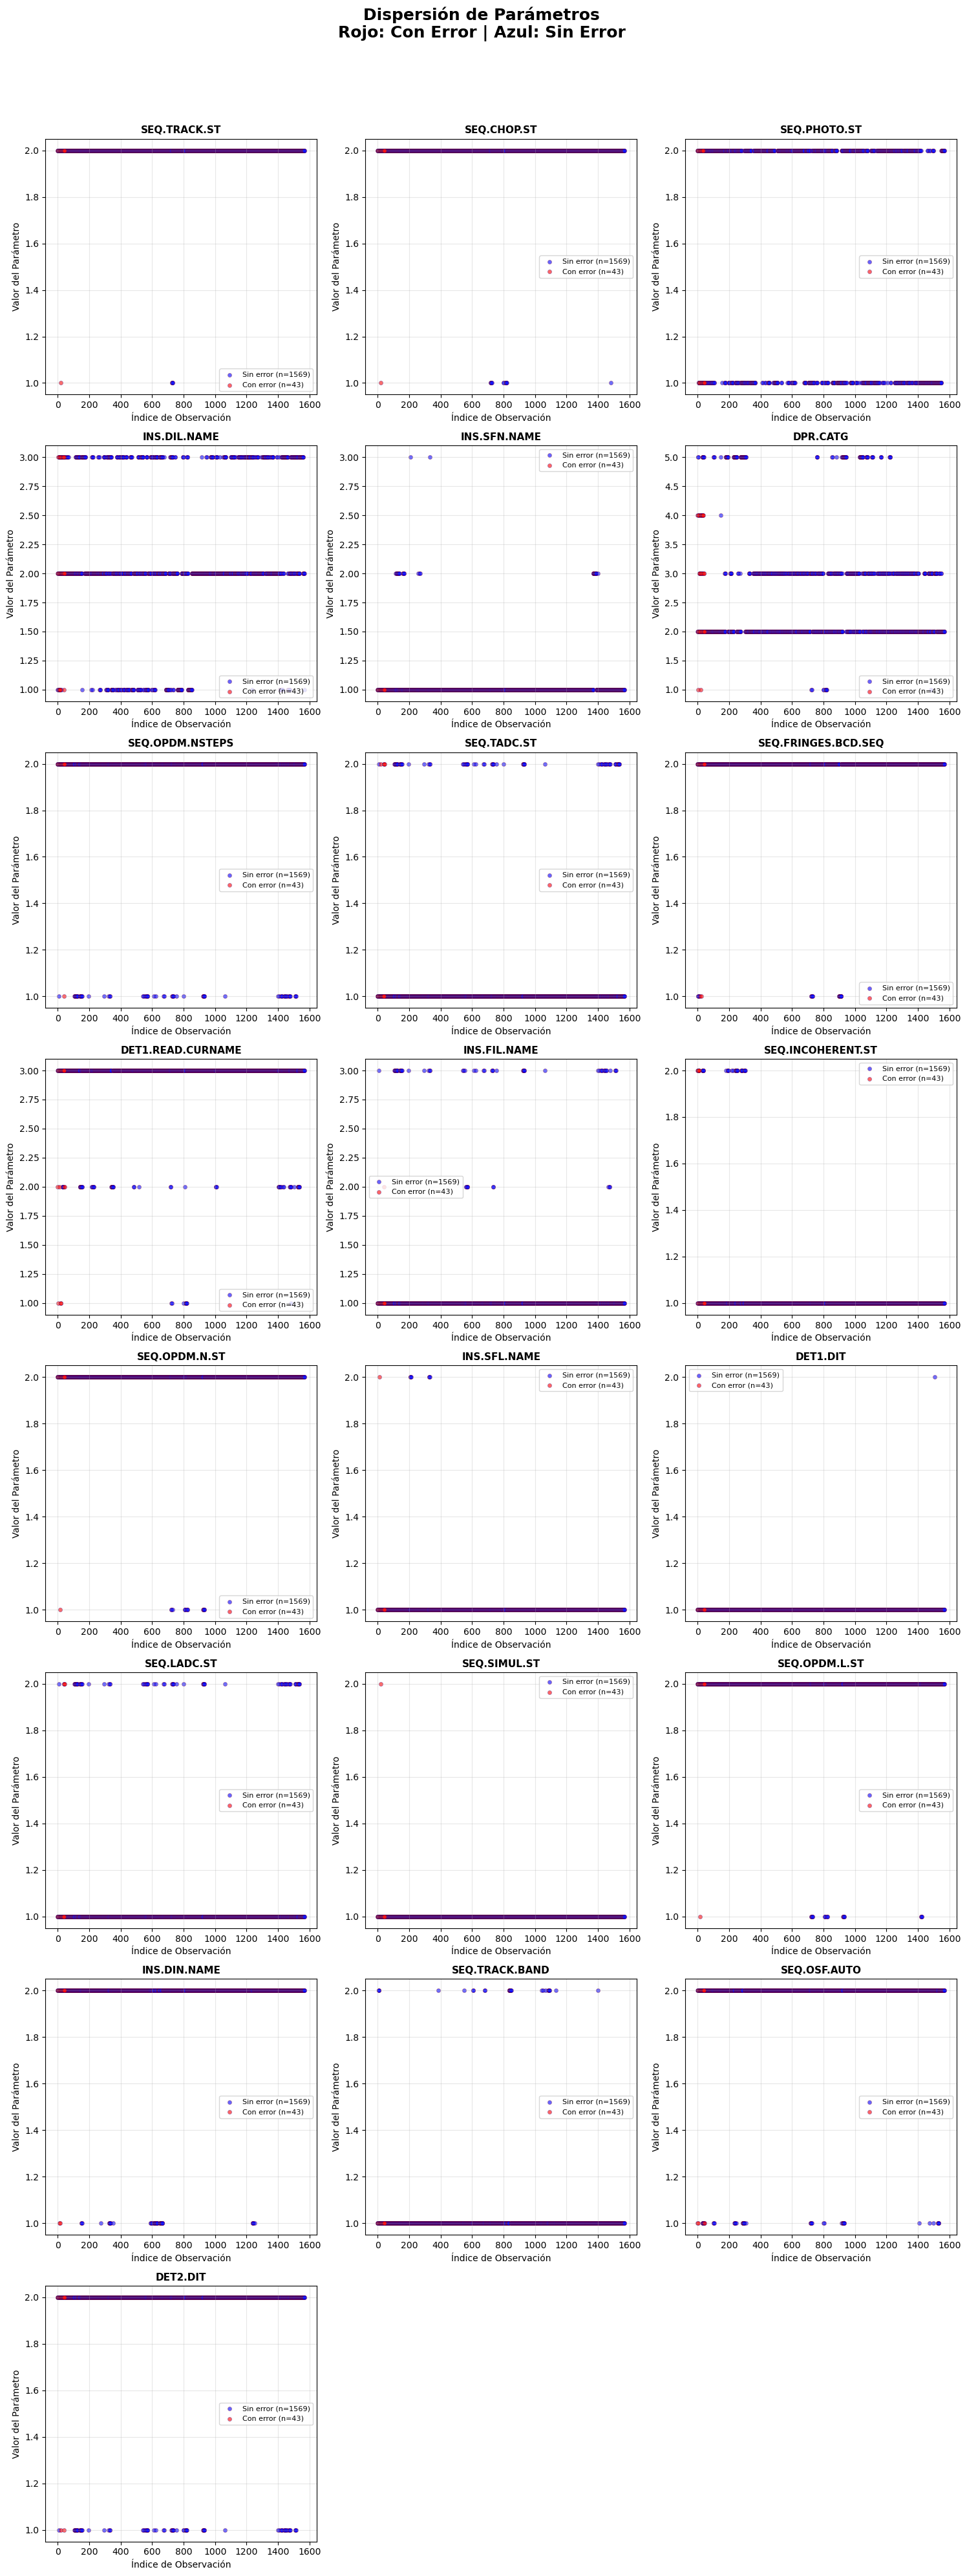


Comparando (Categóricos Codificados) MATISSE_img_acq
Creando gráficos para 20 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.PUP.SKY.DURATION', 'SEQ.TARG.FLUX.N', 'TEL.TARG.PMA', 'TEL.CHOP.THROW', 'DET2.APOX.VAL', 'SEQ.ACQ.DET1.DIT', 'SEQ.ACQ.DET2.DIT', 'DET1.INTERFY.VAL', 'TEL.TARG.ADDVELALPHA', 'DET1.WLMAXCUT.VAL', 'SEQ.SKY.OFFS.ALPHA', 'DET1.APOX.VAL', 'SEQ.DIL.WL0', 'SEQ.ACQ.SKY.DURATION', 'DET2.SNRLIMIT.VAL', 'COU.AG.PMA', 'SEQ.TRACK.BAND', 'DET1.APOTYPE.VAL', 'SEQ.ACQ.INS.FIN.NAME', 'SEQ.OPDM.L.WLMAX', 'DEL.REF.OPL', 'DET2.APOTYPE.VAL', 'TEL.CHOP.POSANG', 'SEQ.FS.TARG.DURATION', 'TEL.CHOP.FREQ', 'DET1.NCOHERENT.VAL', 'SEQ.TARG.MAG.K', 'COU.AG.DELTA', 'COU.AG.EQUINOX', 'SEQ.FS.DET1.DIT', 'SEQ.TARG.FLUX.L', 'DET1.APOY.VAL', 'SEQ.OPDM.L.ST', 'TEL.TARG.ALPHA', 'SEQ.FS.INS.DIN.NAME', 'SEQ.FS.SKY.DURATION', 'SEQ.ACQ.INS.FIL.NAME', 'SEQ.FS.INS.SFL.NAME', 'COU.GS.MAG', 'SEQ.ACQ.TARG.DURATION', 'TEL.CHOP.PVRATIO', 'DET2.READ.CURNAME', 'DET2.NCOHERENT.VAL', 'COU.AG.PM

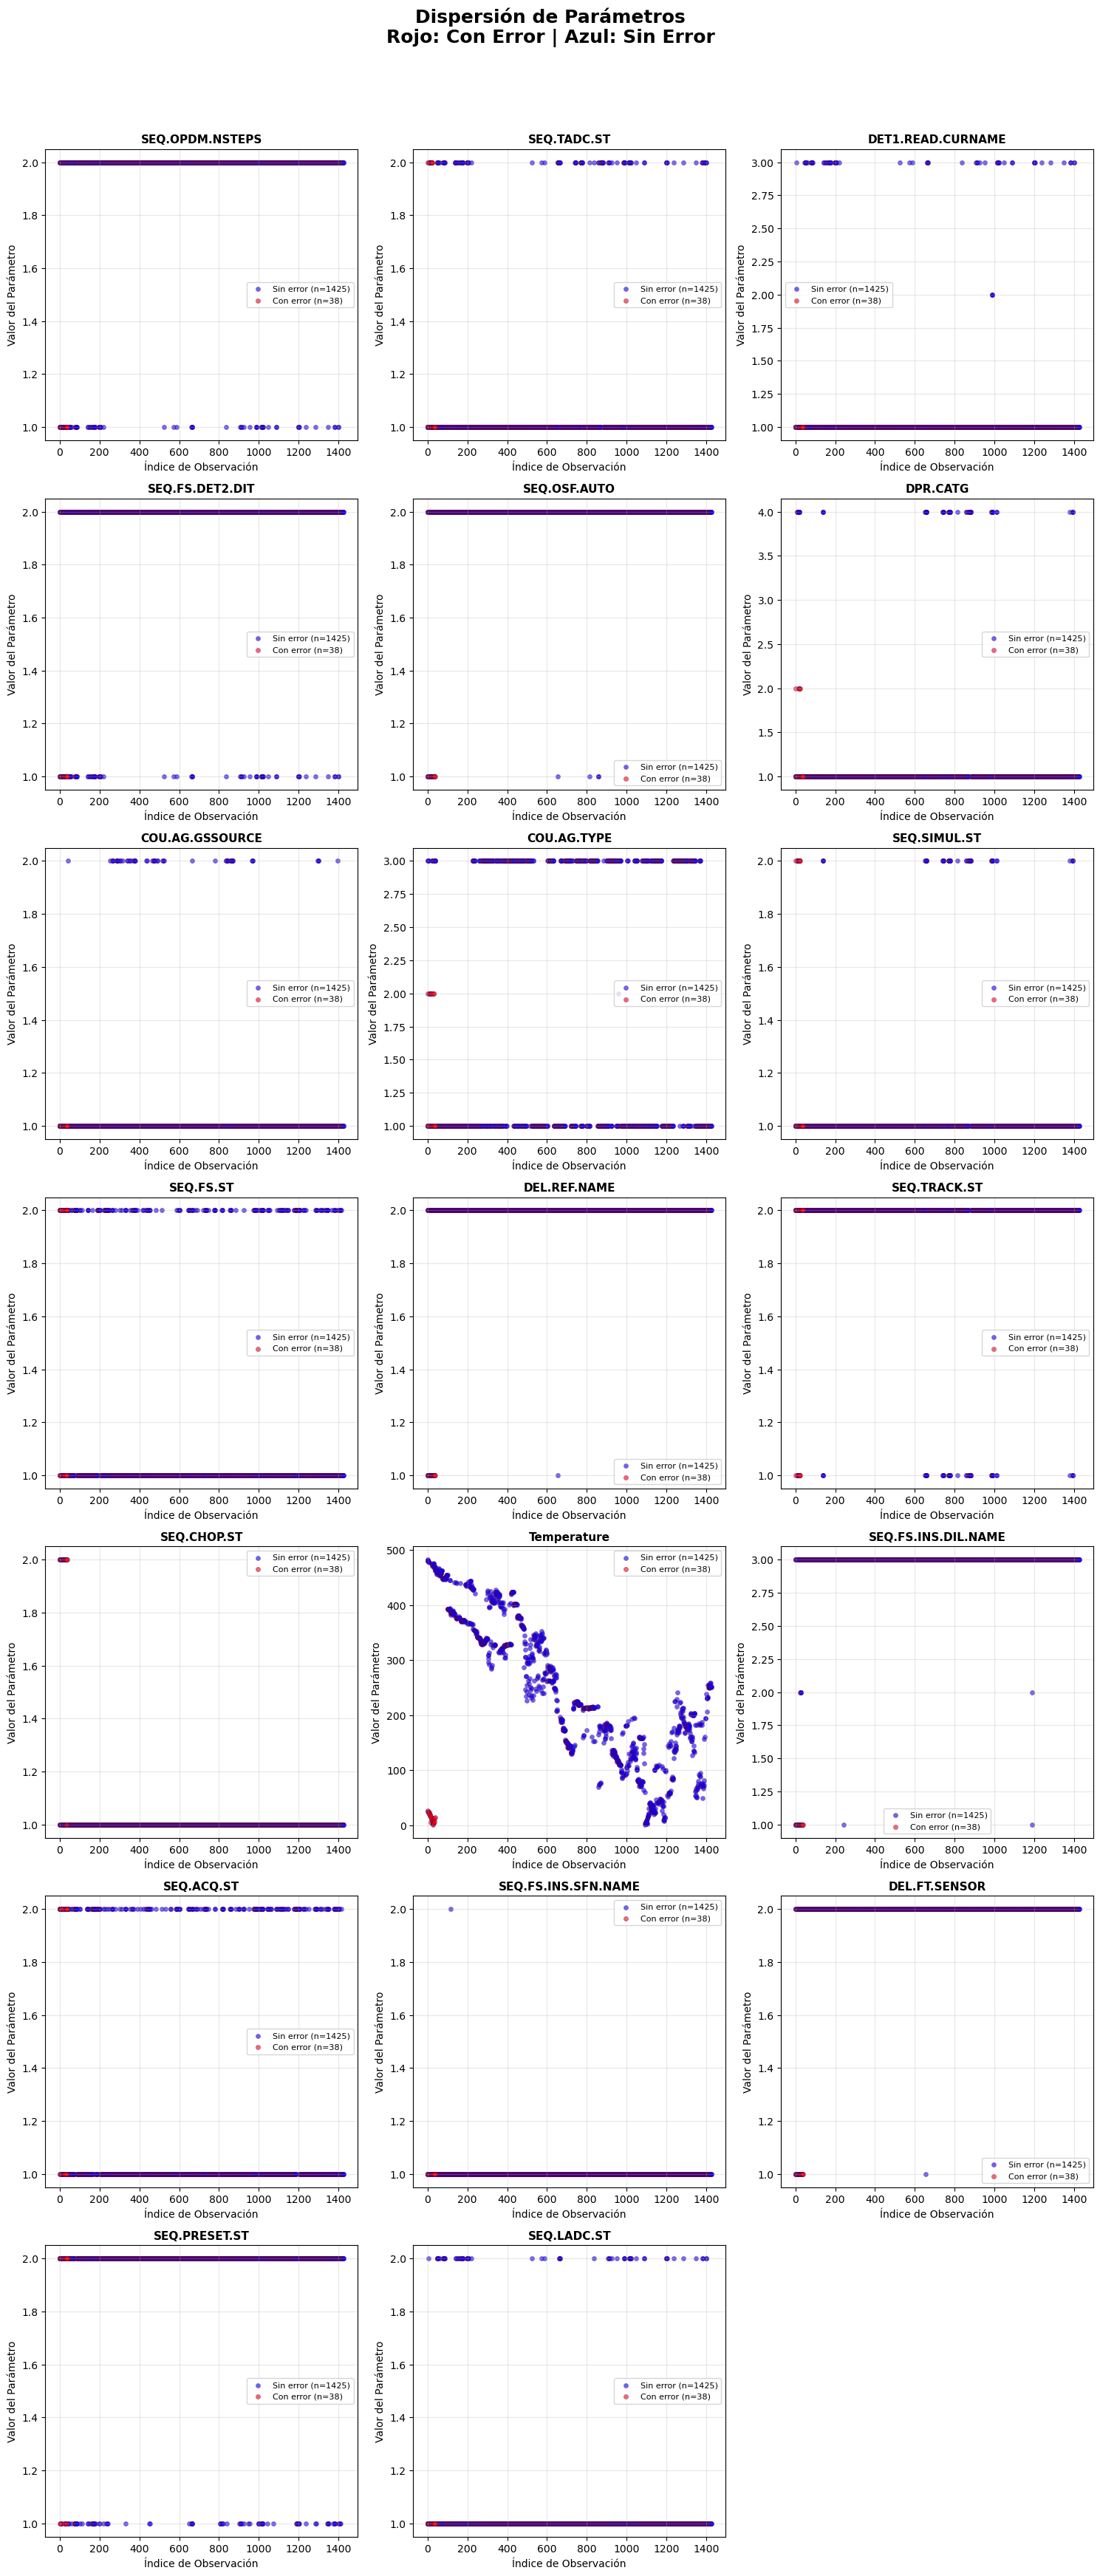


Comparando (Categóricos Codificados) MATISSE_img_acq_ft
Creando gráficos para 9 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.PUP.SKY.DURATION', 'SEQ.TARG.FLUX.N', 'TEL.TARG.PMA', 'DET2.NDIT.SKY', 'DET2.APOX.VAL', 'SEQ.ACQ.DET1.DIT', 'SEQ.ACQ.DET2.DIT', 'DET1.INTERFY.VAL', 'INS.SPEC.RES', 'TEL.TARG.ADDVELALPHA', 'SEQ.FT.MODE', 'DET1.WLMAXCUT.VAL', 'SEQ.SKY.OFFS.ALPHA', 'DET1.APOX.VAL', 'DET1.DIT', 'SEQ.DIL.WL0', 'SEQ.ACQ.SKY.DURATION', 'DET2.SNRLIMIT.VAL', 'COU.AG.PMA', 'DET1.APOTYPE.VAL', 'SEQ.ACQ.INS.FIN.NAME', 'SEQ.OPDM.L.WLMAX', 'DEL.REF.OPL', 'INS.STSOFFANG', 'SEQ.SKY.Y', 'DET2.APOTYPE.VAL', 'COU.AG.GSSOURCE', 'DET1.NCOHERENT.VAL', 'SEQ.TARG.MAG.K', 'COU.AG.DELTA', 'COU.AG.TYPE', 'COU.AG.EQUINOX', 'SEQ.TARG.FLUX.L', 'SEQ.SIMUL.ST', 'DET1.APOY.VAL', 'SEQ.OPDM.L.ST', 'TEL.TARG.ALPHA', 'SEQ.ACQ.INS.FIL.NAME', 'COU.GS.MAG', 'SEQ.ACQ.TARG.DURATION', 'DEL.REF.NAME', 'SEQ.SKY.X', 'INS.SPEC.POL', 'SEQ.CHOP.ST', 'DET2.READ.CURNAME', 'DET2.NCOHERENT.VAL', 'COU.AG.PMD'

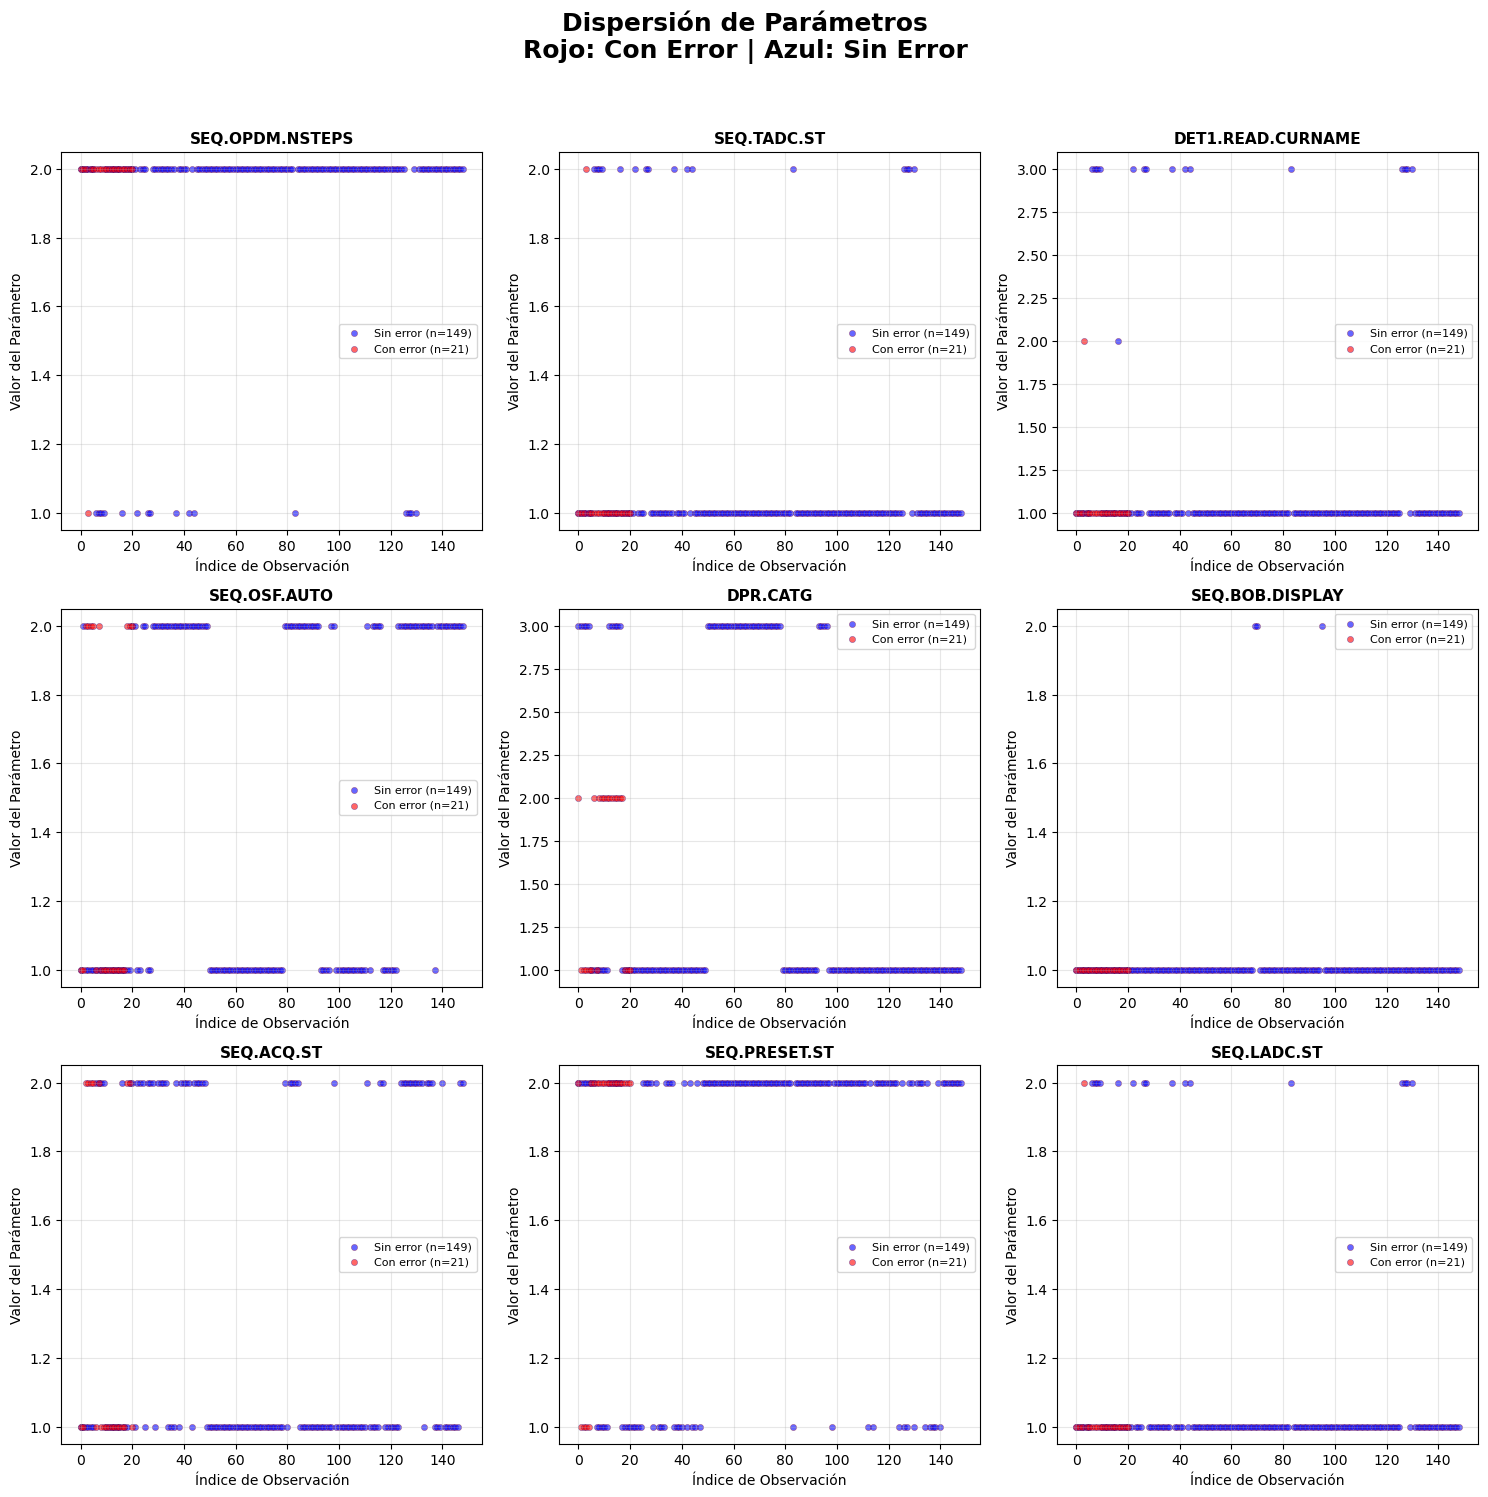

In [24]:
archivos_especificos_tpls = [
    'MATISSE_hyb_obs',
    'MATISSE_img_acq',
    'MATISSE_img_acq_ft'
]
print(f"Generando gráficos para los TPL_IDs (Categóricos Codificados): {', '.join(archivos_especificos_tpls)}")

for tpl_id_str in archivos_especificos_tpls:
    df_ok_codified = codified_strval_ok_dfs.get(tpl_id_str)
    df_err_codified = codified_strval_err_dfs.get(tpl_id_str)

    if df_ok_codified is not None and not df_ok_codified.empty and \
       df_err_codified is not None and not df_err_codified.empty:

        print(f"\nComparando (Categóricos Codificados) {tpl_id_str}")

        threshold = 0.5
        df_ok_cleaned = df_ok_codified.loc[:, df_ok_codified.isna().mean() < threshold]
        df_ok_cleaned = df_ok_cleaned.loc[df_ok_cleaned.isna().mean(axis=1) < threshold, :]

        df_err_cleaned = df_err_codified.loc[:, df_err_codified.isna().mean() < threshold]
        df_err_cleaned = df_err_cleaned.loc[df_err_cleaned.isna().mean(axis=1) < threshold, :]

        if not df_ok_cleaned.empty and not df_err_cleaned.empty:
            columns = list(set(df_ok_cleaned.columns) & set(df_err_cleaned.columns))
            if columns:
                graficos_dispersion_por_columna(df_ok_cleaned[columns], df_err_cleaned[columns])
            else:
                print(f"No hay columnas comunes después de la limpieza para {tpl_id_str}.")
        else:
            print(f"DataFrame vacío después de la limpieza para {tpl_id_str}. Se omite.")
    else:
        print(f"No se encontraron DataFrames codificados válidos para {tpl_id_str}. Se omite la graficación.")


## 3. Normalización, Reducción de Dimensionalidad (t-SNE/UMAP) y Clustering (DBSCAN)

Esta sección aplica técnicas como la normalización Min-Max, **reducción de dimensionalidad con t-SNE y UMAP**, y DBSCAN para identificar patrones y agrupar las observaciones de parámetros numéricos.

### Preparación de Datos y Aplicación de t-SNE/ UMAP DBSCAN
Se utilizan directamente los DataFrames de parámetros numéricos. Se normalizan y se les aplican tanto t-SNE como UMAP para reducción de dimensionalidad, seguidos de DBSCAN para clustering. Se filtran solo los TPL_IDs `MATISSE_hyb_obs`, `MATISSE_img_acq` y `MATISSE_img_acq_ft`.


In [2]:
output_dir_ok_num = "params_por_tpl"
output_dir_err_num = "params_por_tpl_Error"

# Define the specific filenames you want to process
specific_tpl_filenames_to_process = [
    'params_MATISSE_hyb_obs.csv',
    'params_MATISSE_img_acq.csv',
    'params_MATISSE_img_acq_ft.csv'
]

resultados_ok_files, resultados_err_files = procesar_archivos_especificos(
    lista_archivos_ok=specific_tpl_filenames_to_process,
    lista_archivos_err=specific_tpl_filenames_to_process,
    carpeta_ok=output_dir_ok_num,
    carpeta_err=output_dir_err_num,
    usar_umap=False
)
print("\nClustering process finished.")
print(f"Results for OK files: {list(resultados_ok_files.keys())}")
print(f"Results for ERROR files: {list(resultados_err_files.keys())}")

DBSCAN Parameters for params_MATISSE_hyb_obs.csv (OK): eps=0.888, min_samples=7
DBSCAN Parameters for params_MATISSE_img_acq.csv (OK): eps=0.626, min_samples=6
DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (OK): eps=0.567, min_samples=5
DBSCAN Parameters for params_MATISSE_hyb_obs.csv (ERROR): eps=0.556, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq.csv (ERROR): eps=0.441, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (ERROR): eps=0.288, min_samples=5

Clustering process finished.
Results for OK files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']
Results for ERROR files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']


Graficos combinados para t-sne


Gráfico combinado para: params_MATISSE_hyb_obs.csv

--- Procesando y combinando datos para params_MATISSE_hyb_obs.csv ---
DBSCAN Parameters for Combined Data: eps=0.896, min_samples=7
plot_combined_clusters called with: filename_base=params_MATISSE_hyb_obs.csv, use_umap=False


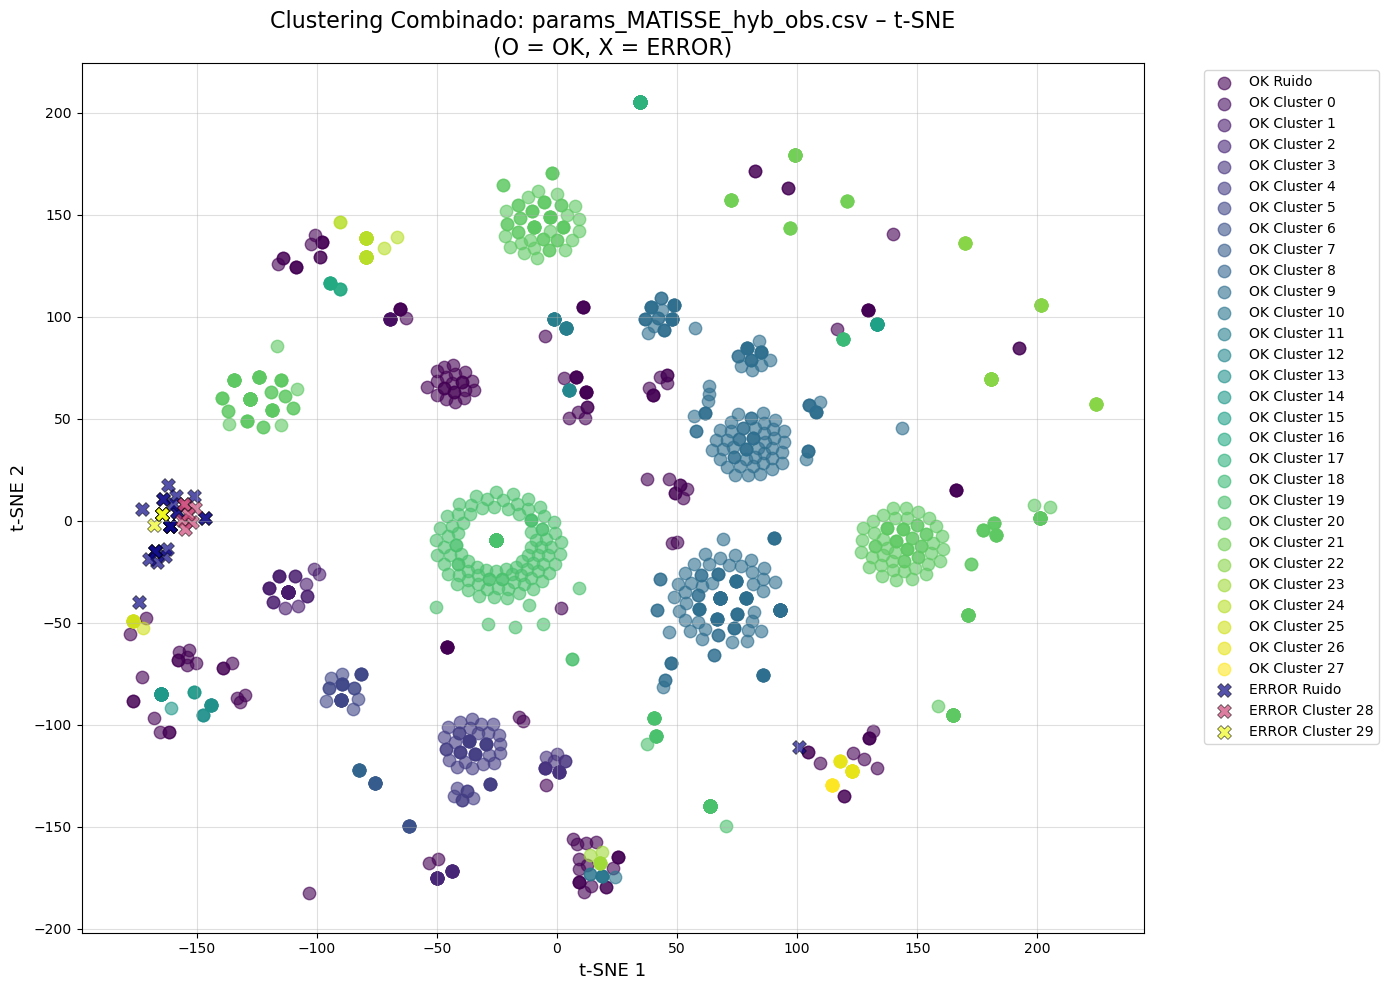


Gráfico combinado para: params_MATISSE_img_acq.csv

--- Procesando y combinando datos para params_MATISSE_img_acq.csv ---
DBSCAN Parameters for Combined Data: eps=0.689, min_samples=7
plot_combined_clusters called with: filename_base=params_MATISSE_img_acq.csv, use_umap=False


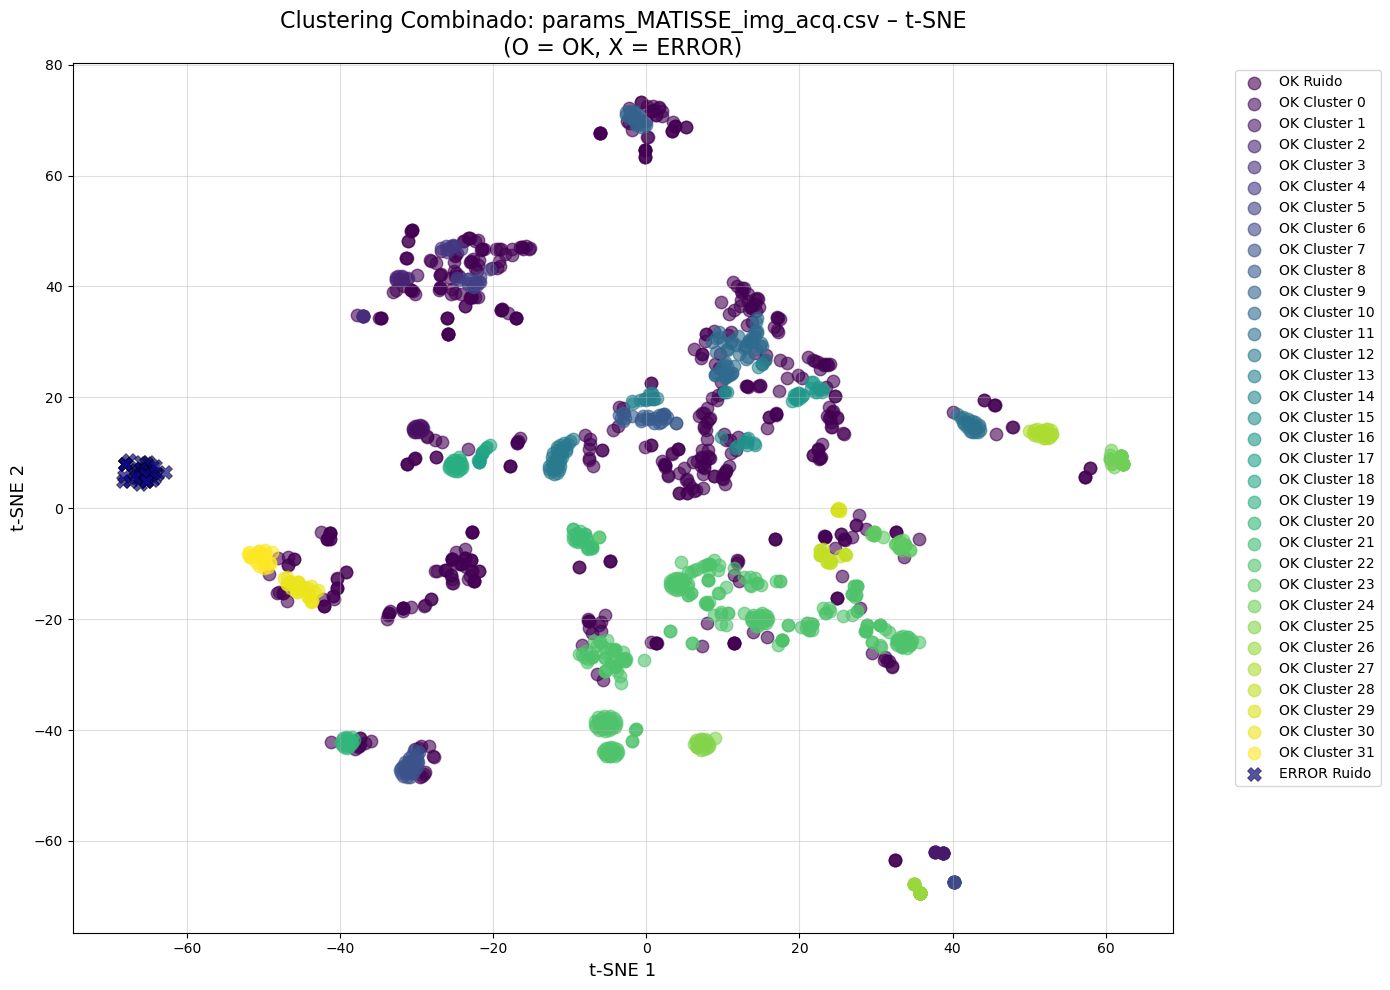


Gráfico combinado para: params_MATISSE_img_acq_ft.csv

--- Procesando y combinando datos para params_MATISSE_img_acq_ft.csv ---
DBSCAN Parameters for Combined Data: eps=0.623, min_samples=5
plot_combined_clusters called with: filename_base=params_MATISSE_img_acq_ft.csv, use_umap=False


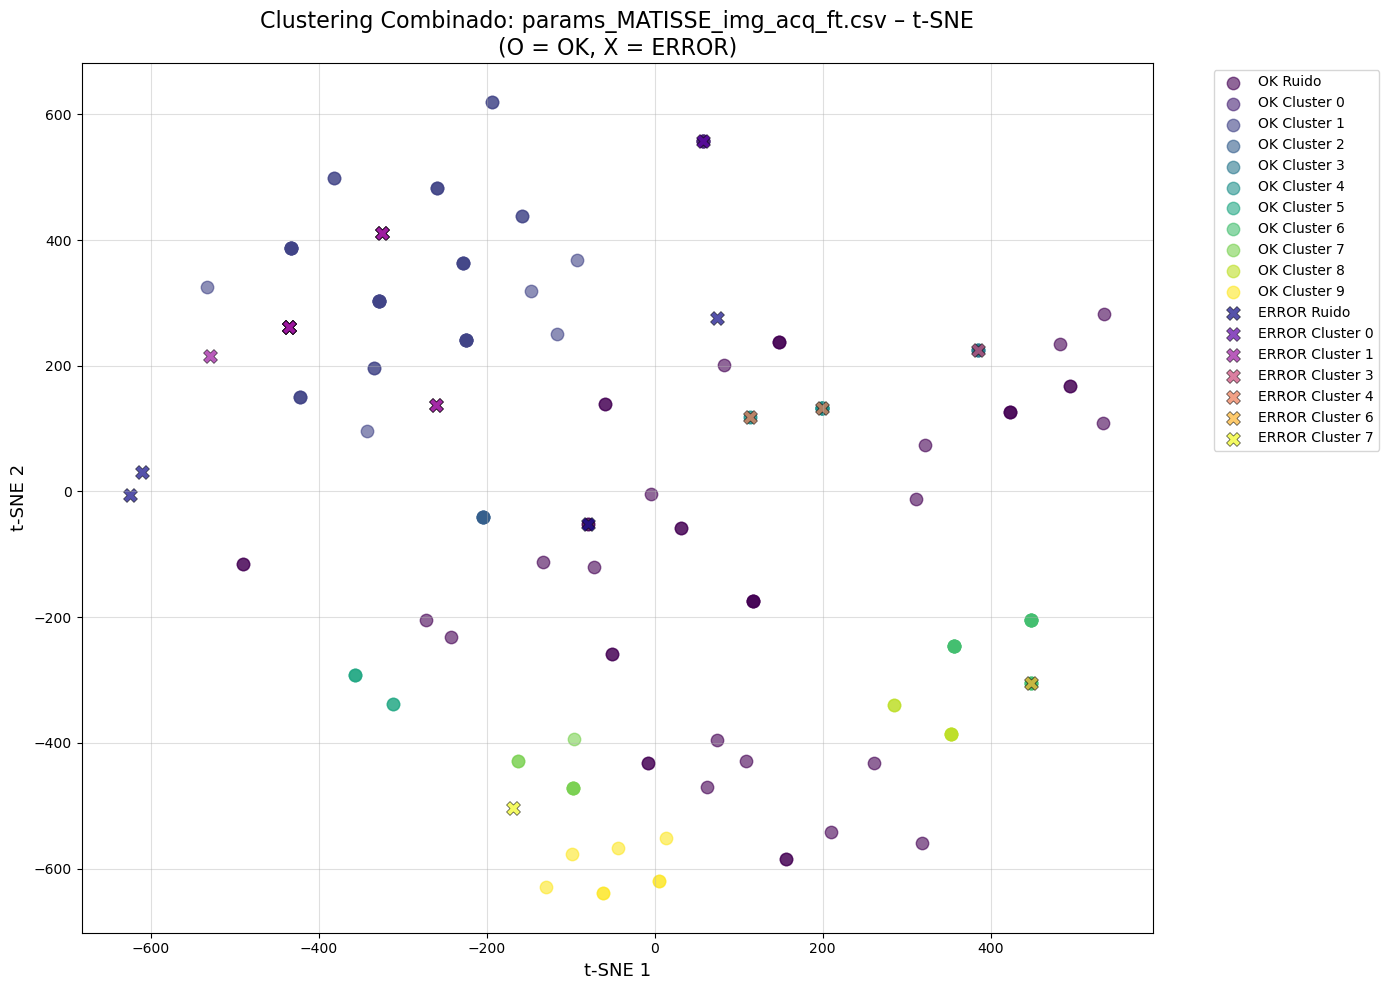

In [5]:
#Graficos combinados
for filename in specific_tpl_filenames_to_process:
    print(f"\nGráfico combinado para: {filename}")
    
    df_ok_path = os.path.join(output_dir_ok_num, filename)
    df_err_path = os.path.join(output_dir_err_num, filename)
    
    if os.path.exists(df_ok_path) and os.path.exists(df_err_path):
        cluster_and_plot_combined(
            df_ok_path=df_ok_path,
            df_err_path=df_err_path,
            filename_base=filename,
            use_umap=False,  
            dbscan_eps=None, 
            dbscan_min_samples=None
        )
    else:
        print(f"  - Advertencia: No se encontraron ambos archivos para {filename}")
        if not os.path.exists(df_ok_path):
            print(f"    Missing OK file: {df_ok_path}")
        if not os.path.exists(df_err_path):
            print(f"    Missing ERROR file: {df_err_path}")


In [6]:
output_dir_ok_num = "params_por_tpl"
output_dir_err_num = "params_por_tpl_Error"

# Define the specific filenames you want to process
specific_tpl_filenames_to_process = [
    'params_MATISSE_hyb_obs.csv',
    'params_MATISSE_img_acq.csv',
    'params_MATISSE_img_acq_ft.csv'
]

resultados_ok_files, resultados_err_files = procesar_archivos_especificos(
    lista_archivos_ok=specific_tpl_filenames_to_process,
    lista_archivos_err=specific_tpl_filenames_to_process,
    carpeta_ok=output_dir_ok_num,
    carpeta_err=output_dir_err_num,
    usar_umap=True
)
print("\nClustering process finished.")
print(f"Results for OK files: {list(resultados_ok_files.keys())}")
print(f"Results for ERROR files: {list(resultados_err_files.keys())}")

DBSCAN Parameters for params_MATISSE_hyb_obs.csv (OK): eps=0.888, min_samples=7


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN Parameters for params_MATISSE_img_acq.csv (OK): eps=0.626, min_samples=6


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (OK): eps=0.567, min_samples=5


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN Parameters for params_MATISSE_hyb_obs.csv (ERROR): eps=0.556, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq.csv (ERROR): eps=0.441, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (ERROR): eps=0.288, min_samples=5

Clustering process finished.
Results for OK files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']
Results for ERROR files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Graficos combiandos para UMAP


Gráfico combinado para: params_MATISSE_hyb_obs.csv

--- Procesando y combinando datos para params_MATISSE_hyb_obs.csv ---
DBSCAN Parameters for Combined Data: eps=0.896, min_samples=7


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


plot_combined_clusters called with: filename_base=params_MATISSE_hyb_obs.csv, use_umap=True


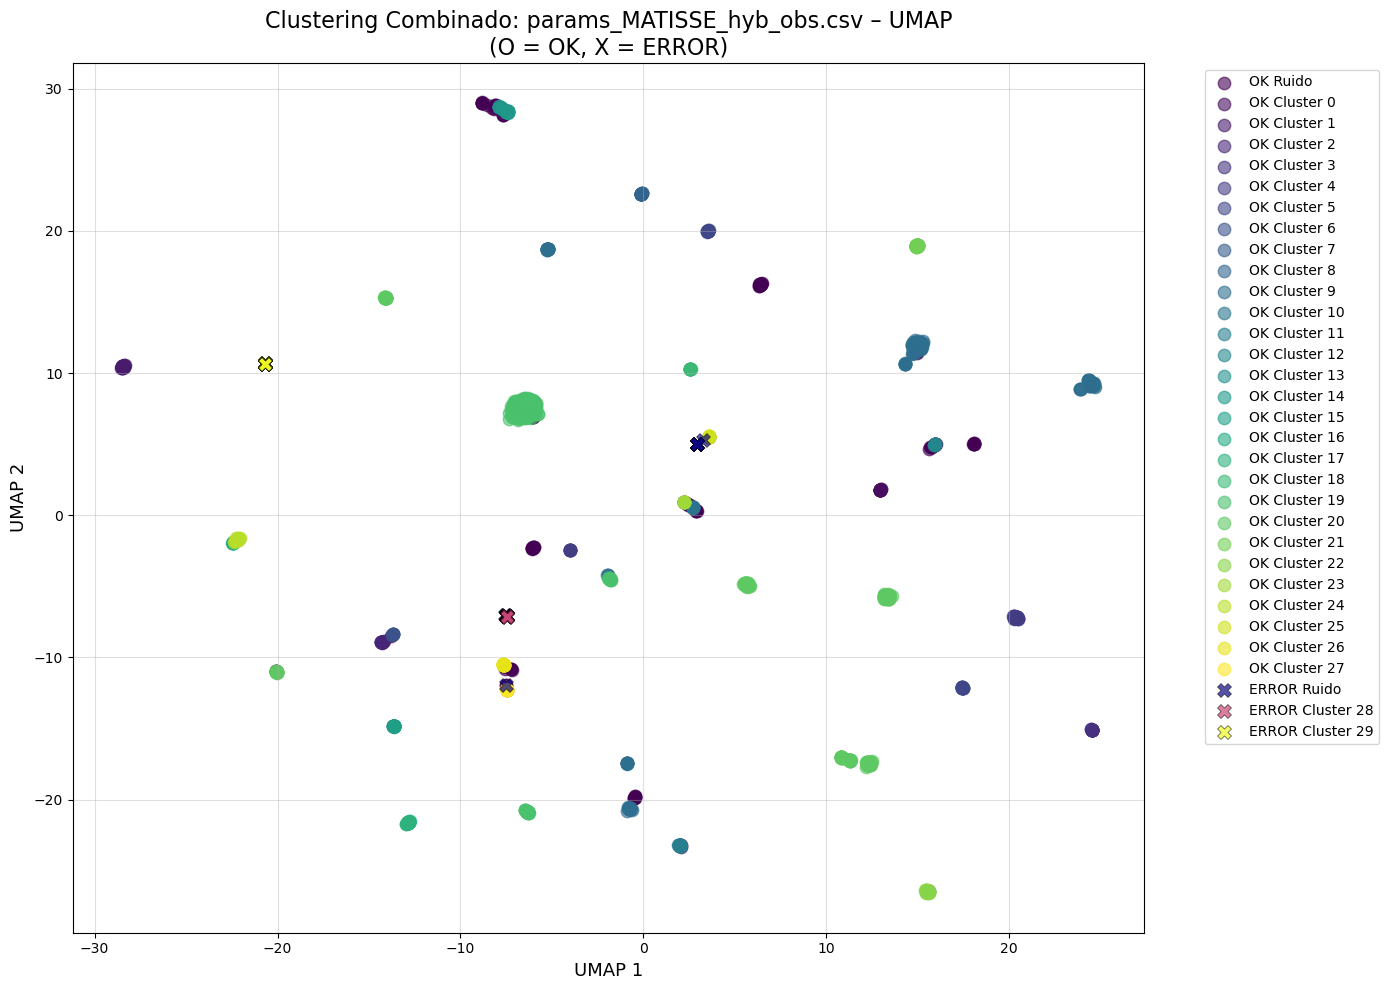


Gráfico combinado para: params_MATISSE_img_acq.csv

--- Procesando y combinando datos para params_MATISSE_img_acq.csv ---
DBSCAN Parameters for Combined Data: eps=0.689, min_samples=7


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


plot_combined_clusters called with: filename_base=params_MATISSE_img_acq.csv, use_umap=True


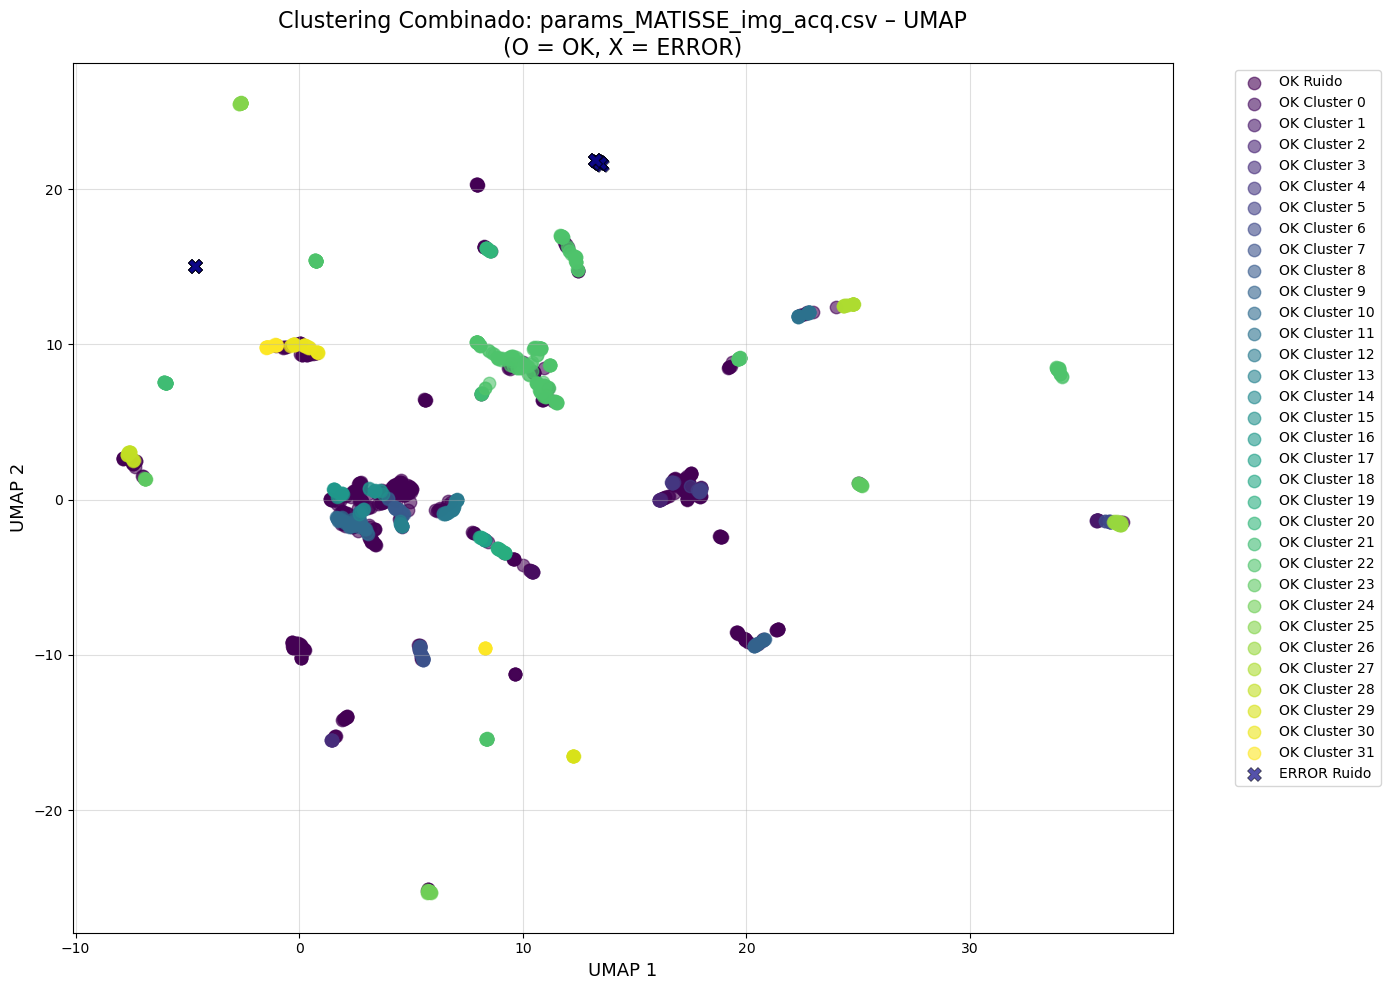


Gráfico combinado para: params_MATISSE_img_acq_ft.csv

--- Procesando y combinando datos para params_MATISSE_img_acq_ft.csv ---
DBSCAN Parameters for Combined Data: eps=0.623, min_samples=5


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


plot_combined_clusters called with: filename_base=params_MATISSE_img_acq_ft.csv, use_umap=True


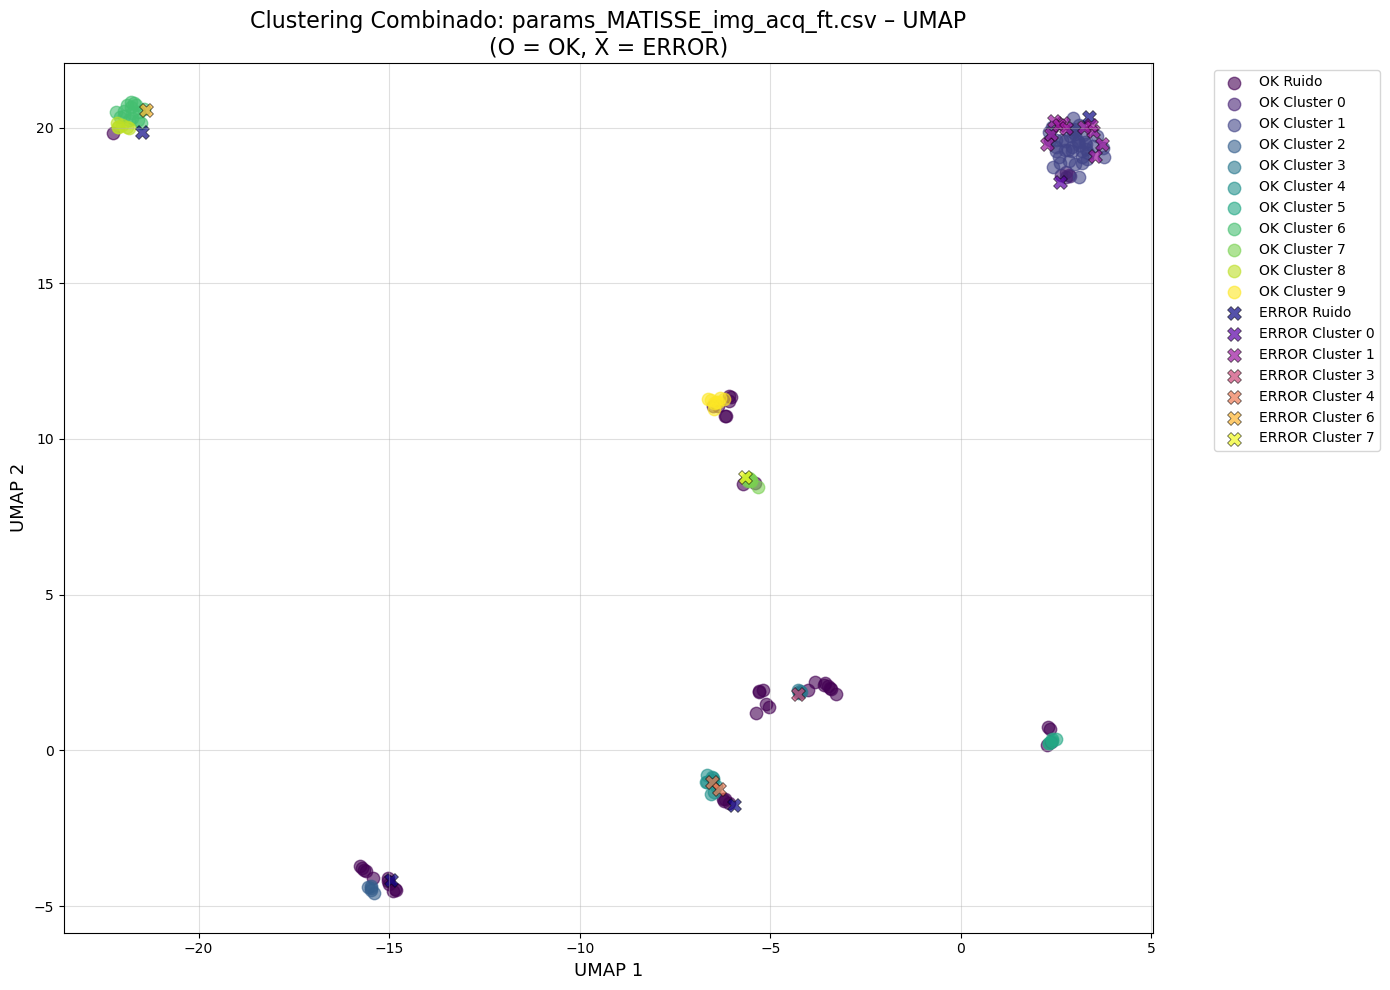

In [7]:
#Graficos combinados
for filename in specific_tpl_filenames_to_process:
    print(f"\nGráfico combinado para: {filename}")
    
    df_ok_path = os.path.join(output_dir_ok_num, filename)
    df_err_path = os.path.join(output_dir_err_num, filename)
    
    if os.path.exists(df_ok_path) and os.path.exists(df_err_path):
        cluster_and_plot_combined(
            df_ok_path=df_ok_path,
            df_err_path=df_err_path,
            filename_base=filename,
            use_umap=True,  
            dbscan_eps=None, 
            dbscan_min_samples=None
        )
    else:
        print(f"  - Advertencia: No se encontraron ambos archivos para {filename}")
        if not os.path.exists(df_ok_path):
            print(f"    Missing OK file: {df_ok_path}")
        if not os.path.exists(df_err_path):
            print(f"    Missing ERROR file: {df_err_path}")